In [156]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import xarray
from tqdm.notebook import tqdm
import seaborn as sns
%matplotlib inline
from sklearn.impute import KNNImputer
# Modelagem do RF
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Análise dos dados gerados
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
import contextily as ctx

### Adiquirindo os Dados

In [157]:
df = pd.read_csv('E:/ML_RS/Qgis/Passo_feio/df_pf_gam_mdt_lsat.csv',
                 header=0, 
                 usecols='fid,lon,lat,TC,Kperc,eU,eTh,U_Th,U_K,Th_K,MDT,COD_UNI_ES,SIGLA_UNID,LS9_B6_SWIR,LS9_B5_NIR,LS9_B4_Red,LS9_B3_Green,LS9_B2_Blue,LS9_B7_SWIR2,LS9_RGB_Falsacor_1,LS9_RGB_Falsacor_2,LS9_RGB_Falsacor_3'.split(','),
                 low_memory=False)

# Conversão para GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:31982")  # SIRGAS 2000 / UTM zone 22S

df = gdf  

In [158]:
column_names = "fid lon lat TC Kperc eU eTh U_Th U_K Th_K MDT COD_UNI_ES SIGLA_UNID LS9_B6_SWIR LS9_B5_NIR LS9_B4_Red LS9_B3_Green LS9_B2_Blue LS9_B7_SWIR2 LS9_RGB_Falsacor_1 LS9_RGB_Falsacor_2 LS9_RGB_Falsacor_3 NDVI geometry".split(' ')
column_names


['fid',
 'lon',
 'lat',
 'TC',
 'Kperc',
 'eU',
 'eTh',
 'U_Th',
 'U_K',
 'Th_K',
 'MDT',
 'COD_UNI_ES',
 'SIGLA_UNID',
 'LS9_B6_SWIR',
 'LS9_B5_NIR',
 'LS9_B4_Red',
 'LS9_B3_Green',
 'LS9_B2_Blue',
 'LS9_B7_SWIR2',
 'LS9_RGB_Falsacor_1',
 'LS9_RGB_Falsacor_2',
 'LS9_RGB_Falsacor_3',
 'NDVI',
 'geometry']

### Visualização Geral dos Dados

In [159]:
df.describe()

,fid,lon,lat,TC,Kperc,eU,eTh,U_Th,U_K,Th_K,...,COD_UNI_ES,LS9_B6_SWIR,LS9_B5_NIR,LS9_B4_Red,LS9_B3_Green,LS9_B2_Blue,LS9_B7_SWIR2,LS9_RGB_Falsacor_1,LS9_RGB_Falsacor_2,LS9_RGB_Falsacor_3
count,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,...,6237.000000,6253.000000,6253.000000,6253.000000,6253.000000,6253.000000,6253.000000,6455.000000,6455.000000,6455.000000
mean,3240.500000,-53.564996,-30.635005,0.500039,0.494855,0.501498,0.489132,5.329372,7.485620,12.198262,...,2217.307520,10252.115625,17495.964017,8599.580681,8984.144091,8111.893171,10252.115625,63.807591,87.724555,39.584198
std,1870.759204,0.037876,0.079246,0.289611,0.288567,0.286502,0.288364,98.575916,150.306415,589.482663,...,1591.257019,1219.420879,2733.728247,595.341097,599.665233,310.157696,1219.420879,15.944361,19.107456,9.962013
min,1.000000,-53.629990,-30.769983,0.000044,0.000004,0.000505,0.000029,0.000717,0.000718,0.000067,...,135.000000,7397.000000,7687.000000,7315.000000,7477.000000,7334.000000,7397.000000,0.000000,0.000000,0.000000
25%,1620.750000,-53.597493,-30.702494,0.248856,0.244507,0.255996,0.237625,0.510615,0.517667,0.493398,...,152.000000,9328.000000,15758.000000,8148.000000,8513.000000,7885.000000,9328.000000,58.500000,84.000000,36.000000
50%,3240.500000,-53.564996,-30.635005,0.499756,0.492584,0.506608,0.476460,1.027505,1.010362,0.995360,...,2711.000000,10181.000000,17556.000000,8525.000000,8949.000000,8096.000000,10181.000000,66.000000,91.000000,41.000000
75%,4860.250000,-53.532499,-30.567516,0.750780,0.744987,0.746949,0.738907,2.101909,2.038083,1.985643,...,3661.000000,11062.000000,19270.000000,8970.000000,9421.000000,8308.000000,11062.000000,74.000000,98.000000,45.000000
max,6480.000000,-53.500002,-30.500027,0.999761,0.999953,0.999603,0.999844,7550.956899,9793.230459,47292.650373,...,7252.000000,15615.000000,27315.000000,12372.000000,11667.000000,10137.000000,15615.000000,98.000000,125.000000,65.000000


### Organização e visualização dos dados

In [160]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6480 entries, 0 to 6479
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   fid                 6480 non-null   int64   
 1   lon                 6480 non-null   float64 
 2   lat                 6480 non-null   float64 
 3   TC                  6480 non-null   float64 
 4   Kperc               6480 non-null   float64 
 5   eU                  6480 non-null   float64 
 6   eTh                 6480 non-null   float64 
 7   U_Th                6480 non-null   float64 
 8   U_K                 6480 non-null   float64 
 9   Th_K                6480 non-null   float64 
 10  MDT                 6195 non-null   float64 
 11  COD_UNI_ES          6237 non-null   float64 
 12  SIGLA_UNID          6237 non-null   object  
 13  LS9_B6_SWIR         6253 non-null   float64 
 14  LS9_B5_NIR          6253 non-null   float64 
 15  LS9_B4_Red          6253 non-n

### Limpando os dados

In [161]:
# 1. Separar colunas por tipo e significado (mantendo sua estrutura original)
geo_cols = ['lon', 'lat', 'MDT']
radiometric_cols = ['TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K']
spectral_cols = [c for c in df.columns if 'LS9_' in c]
categorical_cols = ['SIGLA_UNID']
id_cols = ['fid', 'COD_UNI_ES']

# 2. Tratamento para dados categóricos - REMOVER NAs em vez de criar UNKNOWN
print("Distribuição original de SIGLA_UNID:\n", df['SIGLA_UNID'].value_counts())
print(f"\nLinhas com SIGLA_UNID faltante: {df['SIGLA_UNID'].isna().sum()}")

# Remover linhas onde SIGLA_UNID é NA 
df = df.dropna(subset=['SIGLA_UNID']).copy()
print("\nDistribuição após remoção:\n", df['SIGLA_UNID'].value_counts())

# 3. Tratamento diferenciado para variáveis numéricas

# A. Dados Geoespaciais - interpolação espacial condicional
# (só preenche se tiver pelo menos 2 pontos válidos)
for col in geo_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].interpolate(method='linear')
        # Se ainda houver NAs (pontos nas extremidades), remove
        df = df.dropna(subset=[col])

# B. Dados Radiométricos - imputação robusta com verificação

if df[radiometric_cols].isna().sum().sum() > 0:
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df[radiometric_cols] = imputer.fit_transform(df[radiometric_cols])

# C. Bandas Espectrais - normalização + interpolação

scaler = RobustScaler()
df[spectral_cols] = scaler.fit_transform(df[spectral_cols])

# Preencher eventuais NAs restantes (se houver)
df[spectral_cols] = df[spectral_cols].interpolate(method='linear', limit_direction='both')

# 4. Engenharia de features geoespaciais melhorada
# NDVI com verificação de divisão por zero
df['NDVI'] = (df['LS9_B5_NIR'] - df['LS9_B4_Red']) / (df['LS9_B5_NIR'] + df['LS9_B4_Red'] + 1e-10)
df['NDVI'] = df['NDVI'].clip(-1, 1)  # Garantir valores dentro do range teórico

# Razões entre bandas com proteção contra outliers
def safe_ratio(a, b, max_val=10):
    ratio = a / (b + 1e-10)
    return np.clip(ratio, -max_val, max_val)

df['Ratio_B5_B4'] = safe_ratio(df['LS9_B5_NIR'], df['LS9_B4_Red'])
df['Ratio_B7_B6'] = safe_ratio(df['LS9_B7_SWIR2'], df['LS9_B6_SWIR'])

# 5. Verificação final 
print("\nValores faltantes após tratamento:")
print(df.isna().sum())

# Verificação de valores extremos
def check_outliers(col, threshold=3):
    z_scores = (df[col] - df[col].mean()) / df[col].std()
    return df[abs(z_scores) > threshold][[col]]

print("\nValores extremos em U_Th:")
print(check_outliers('U_Th'))

# Verificação geoespacial
print(f"\nMDT range: {df['MDT'].min():.2f} to {df['MDT'].max():.2f}")
print(f"Coordenadas únicas: {df[['lon','lat']].drop_duplicates().shape[0]} de {len(df)} pontos")

Distribuição original de SIGLA_UNID:
 SIGLA_UNID
NP12vpf             1277
NP3sl                851
NP3sf                663
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3ps                508
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
NP12vpfc              87
NP12vpfm              22
Name: count, dtype: int64

Linhas com SIGLA_UNID faltante: 243

Distribuição após remoção:
 SIGLA_UNID
NP12vpf             1277
NP3sl                851
NP3sf                663
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3ps                508
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
NP12vpfc              87
NP12vpfm              22
Name: count, dtype: int64

Valores faltantes após tratamento:
fid                   0
lon                   0
lat                   0
TC                    0
Kperc                 0
eU                    0
eTh                   0
U_Th              

In [162]:
df.describe()

,fid,lon,lat,TC,Kperc,eU,eTh,U_Th,U_K,Th_K,...,LS9_B4_Red,LS9_B3_Green,LS9_B2_Blue,LS9_B7_SWIR2,LS9_RGB_Falsacor_1,LS9_RGB_Falsacor_2,LS9_RGB_Falsacor_3,NDVI,Ratio_B5_B4,Ratio_B7_B6
count,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,...,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000
mean,3119.000000,-53.563955,-30.637555,0.501023,0.493488,0.501254,0.488914,5.213810,7.701907,12.577214,...,0.089735,0.038931,0.035425,0.041211,-0.076116,-0.032616,-0.014719,0.000139,0.508513,0.999519
std,1800.611146,0.037076,0.077860,0.289447,0.288297,0.286626,0.288156,99.602143,153.201431,600.853114,...,0.724251,0.660766,0.733592,0.703807,0.752828,0.788182,0.710477,0.652484,3.046411,0.021928
min,1.000000,-53.627560,-30.769983,0.000044,0.000004,0.000505,0.000029,0.000717,0.000718,0.000067,...,-1.472788,-1.621145,-1.803783,-1.606231,-4.466667,-6.500000,-4.100000,-1.000000,-10.000000,0.000000
25%,1560.000000,-53.595974,-30.705926,0.250158,0.244157,0.255953,0.237337,0.509206,0.518512,0.493705,...,-0.459714,-0.480176,-0.501182,-0.491562,-0.533333,-0.500000,-0.500000,-0.487839,-0.178293,1.000000
50%,3119.000000,-53.564389,-30.637293,0.500552,0.490491,0.507136,0.477053,1.027495,1.010946,0.996411,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027081,0.624773,1.000000
75%,4678.000000,-53.531588,-30.568660,0.751697,0.742285,0.746652,0.737958,2.113256,2.042347,1.997258,...,0.539982,0.519824,0.498818,0.508294,0.466667,0.500000,0.500000,0.439185,1.419891,1.000000
max,6237.000000,-53.500002,-30.504603,0.999761,0.999953,0.999603,0.999844,7550.956899,9793.230459,47292.650373,...,4.677410,2.993392,4.822695,3.135151,2.066667,2.428571,2.400000,1.000000,10.000000,1.000000


### Visualização dos dados

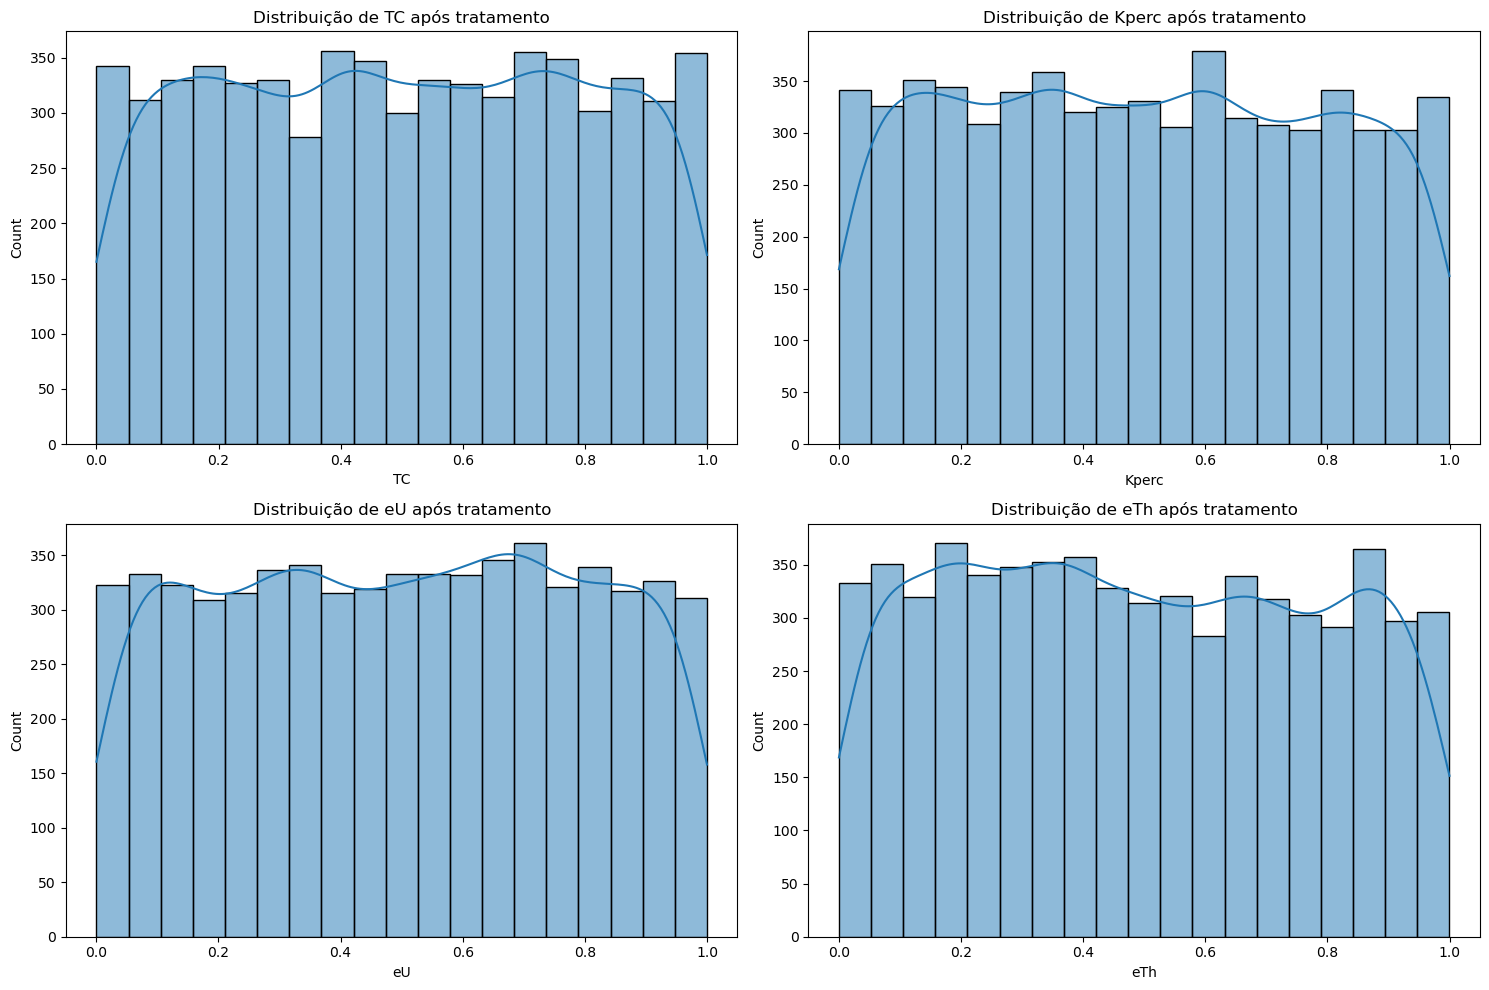

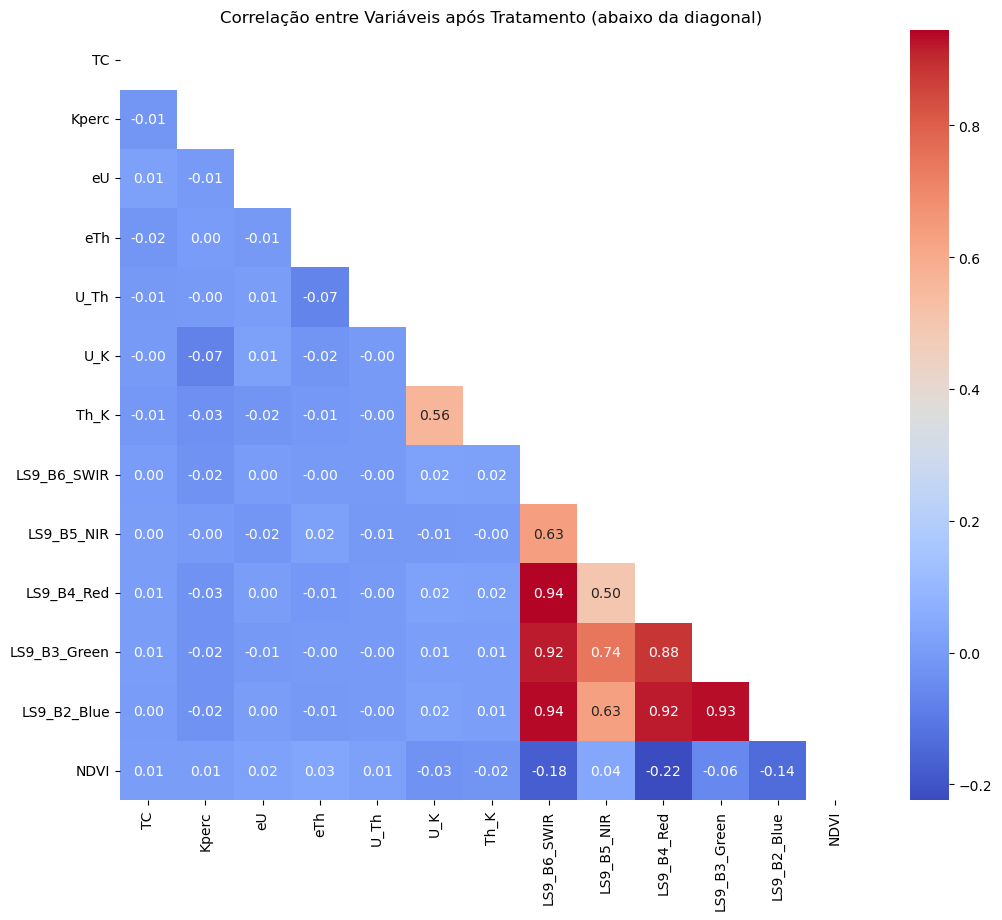

SIGLA_UNID
NP12vpf             1277
NP3sl                851
NP3sf                663
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3ps                508
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
NP12vpfc              87
NP12vpfm              22
Name: count, dtype: int64


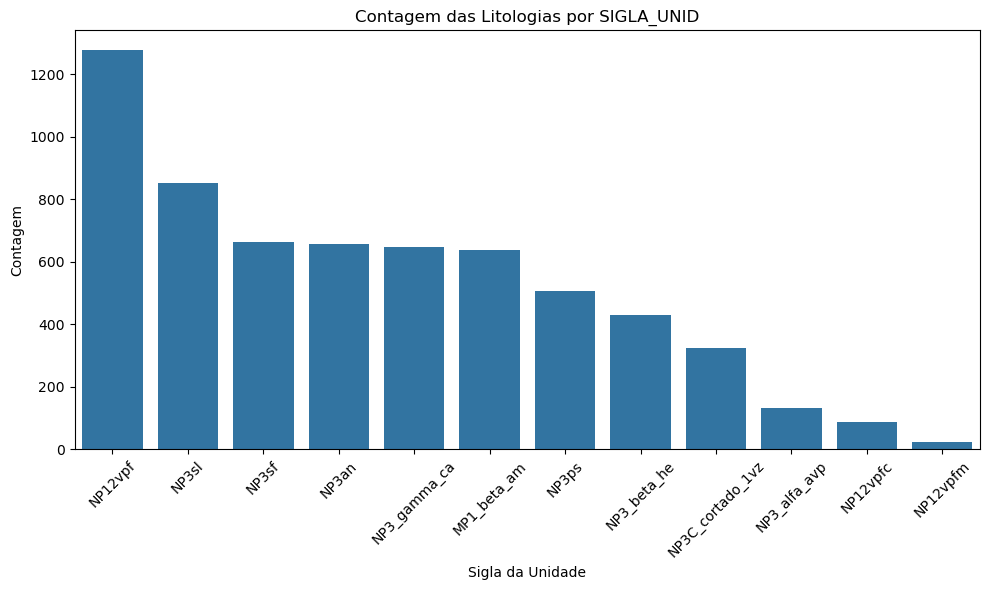

In [163]:
# 1. Verifique distribuições das variáveis tratadas
plt.figure(figsize=(15, 10))
for i, col in enumerate(radiometric_cols[:4], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col} após tratamento')
plt.tight_layout()
plt.show()

# 2. Mapa de correlação
corr_matrix = df[radiometric_cols + spectral_cols[:5] + ['NDVI']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara para a parte superior (incluindo a diagonal)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f',
            mask=mask)  # Aplica a máscara
plt.title('Correlação entre Variáveis após Tratamento (abaixo da diagonal)')
plt.show()

contagem_dos_locais = df['SIGLA_UNID'].value_counts()
print(contagem_dos_locais)
# Criar o gráfico de barras
plt.figure(figsize=(10, 6)) 
sns.barplot(x=contagem_dos_locais.index, y=contagem_dos_locais.values)

# Adicionar títulos e formatação
plt.title('Contagem das Litologias por SIGLA_UNID')
plt.xlabel('Sigla da Unidade')
plt.ylabel('Contagem')
plt.xticks(rotation=45) 
# Mostrar o gráfico
plt.tight_layout() 
plt.show()

### Análise das Litologias similares

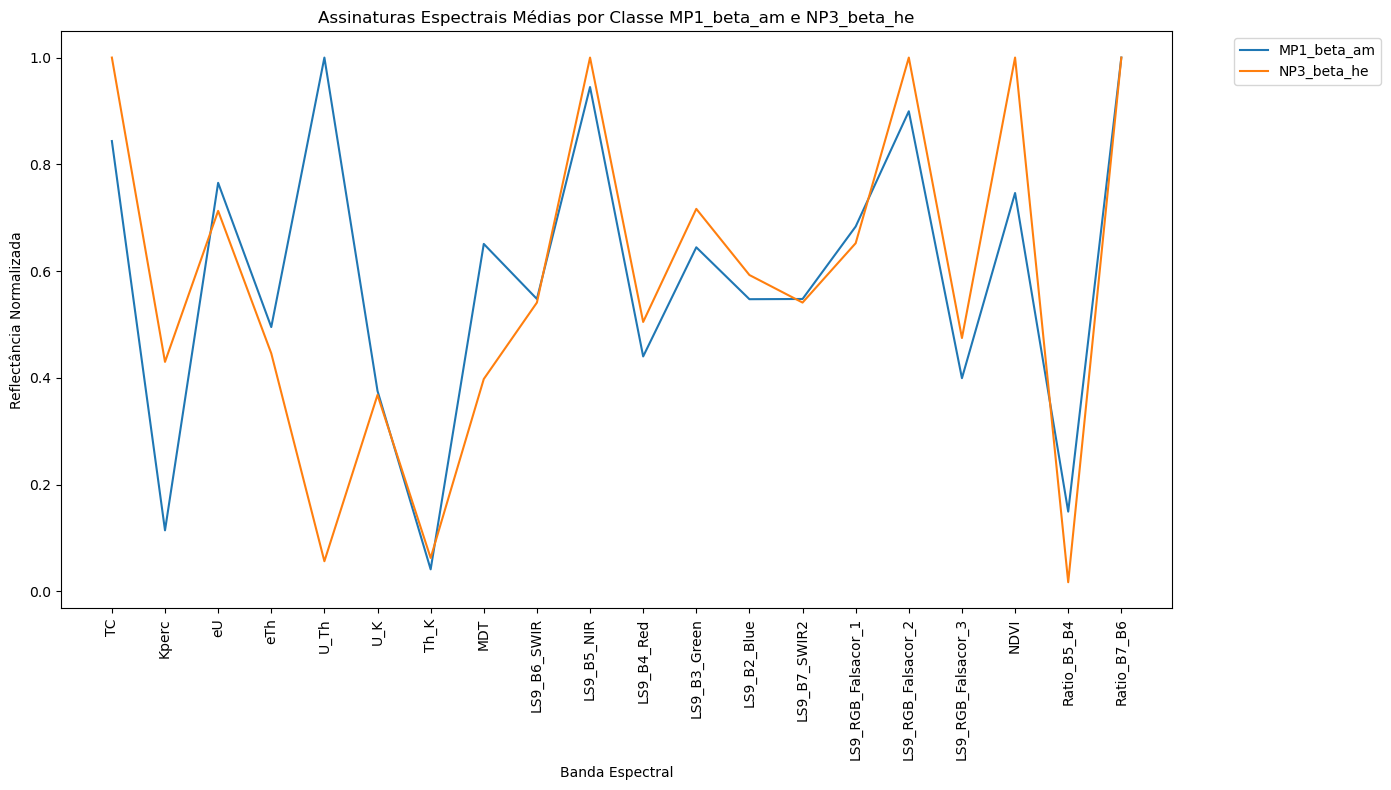

In [164]:
# Calcular médias por classe (excluindo colunas não espectrais)
spectral_bands = [col for col in df.columns if col not in ['SIGLA_UNID', 'COD_UNI_ES', 'fid', 'lon', 'lat', 'geometry']]
class_means = df.groupby('SIGLA_UNID')[spectral_bands].mean()

# Normalizar para comparação
class_means_norm = (class_means - class_means.min()) / (class_means.max() - class_means.min())

# Lista das classes 
classes_para_plotar = ['MP1_beta_am', 'NP3_beta_he'] 

# Filtrar o DataFrame normalizado pelas classes de interesse
class_means_filtrado = class_means_norm.loc[classes_para_plotar]

# Plot
plt.figure(figsize=(14, 8))
for cls in class_means_filtrado.index:
    plt.plot(class_means_filtrado.columns, class_means_filtrado.loc[cls], label=cls)
plt.xticks(rotation=90)
plt.xlabel('Banda Espectral')
plt.ylabel('Reflectância Normalizada')
plt.title('Assinaturas Espectrais Médias por Classe MP1_beta_am e NP3_beta_he')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

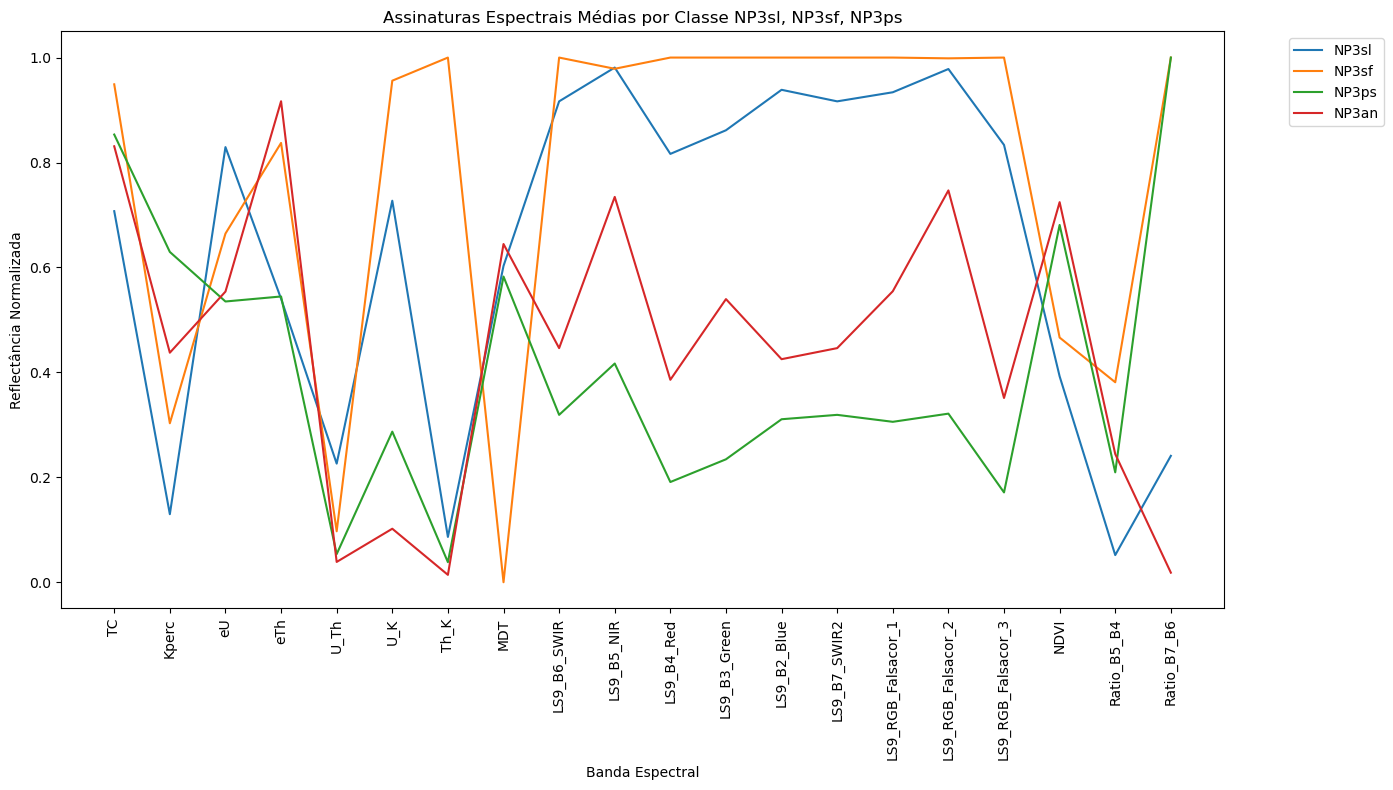

In [165]:
# Calcular médias por classe (excluindo colunas não espectrais)
spectral_bands = [col for col in df.columns if col not in ['SIGLA_UNID', 'COD_UNI_ES', 'fid', 'lon', 'lat', 'geometry']]
class_means = df.groupby('SIGLA_UNID')[spectral_bands].mean()

# Normalizar para comparação
class_means_norm = (class_means - class_means.min()) / (class_means.max() - class_means.min())

# Lista das classes
classes_para_plotar = ['NP3sl', 'NP3sf', 'NP3ps', 'NP3an'] 

# Filtrar o DataFrame normalizado pelas classes de interesse
class_means_filtrado = class_means_norm.loc[classes_para_plotar]

# Plot
plt.figure(figsize=(14, 8))
for cls in class_means_filtrado.index:
    plt.plot(class_means_filtrado.columns, class_means_filtrado.loc[cls], label=cls)
plt.xticks(rotation=90)
plt.xlabel('Banda Espectral')
plt.ylabel('Reflectância Normalizada')
plt.title('Assinaturas Espectrais Médias por Classe NP3sl, NP3sf, NP3ps')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

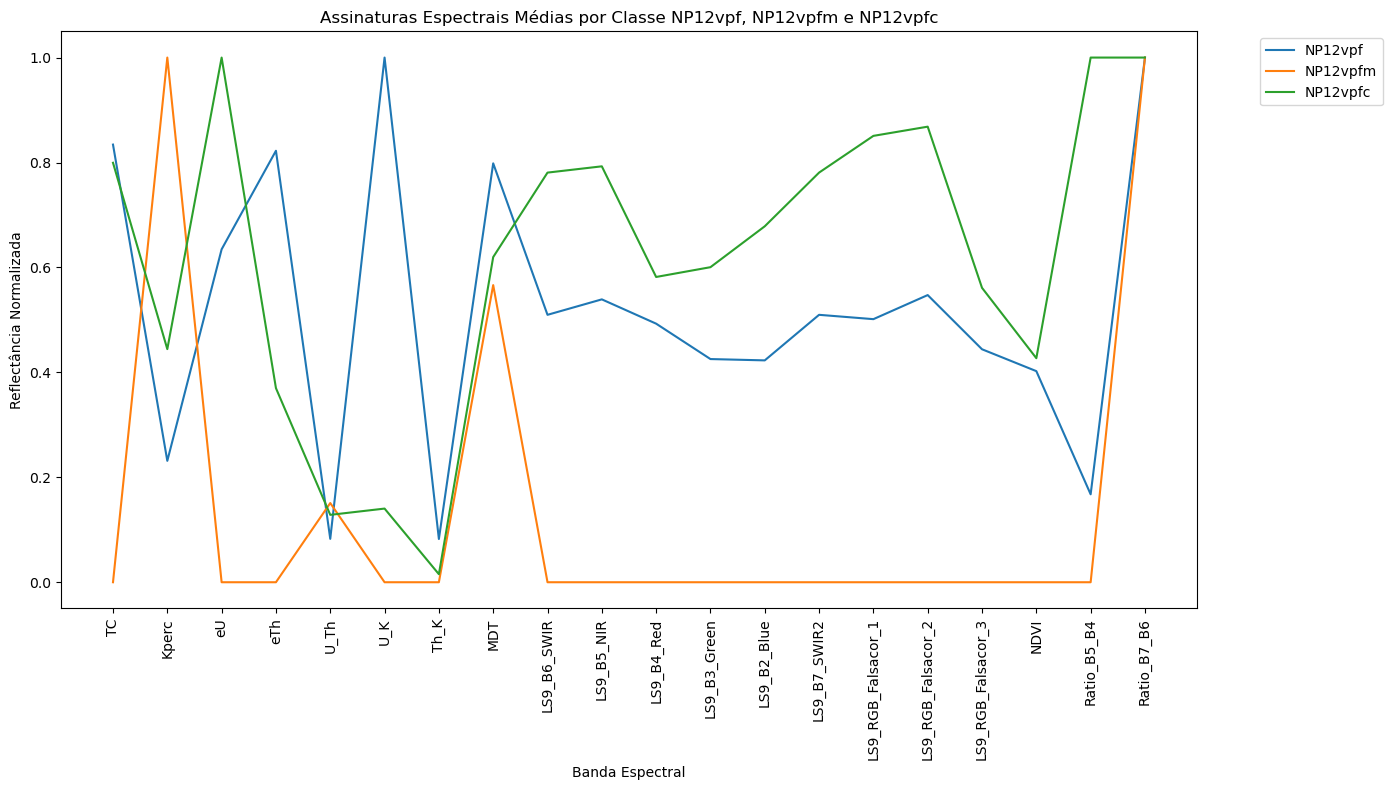

In [166]:
# Calcular médias por classe (excluindo colunas não espectrais)
spectral_bands = [col for col in df.columns if col not in ['SIGLA_UNID', 'COD_UNI_ES', 'fid', 'lon', 'lat', 'geometry']]
class_means = df.groupby('SIGLA_UNID')[spectral_bands].mean()

# Normalizar para comparação
class_means_norm = (class_means - class_means.min()) / (class_means.max() - class_means.min())

# Lista das classes 
classes_para_plotar = ['NP12vpf', 'NP12vpfm', 'NP12vpfc']

# Filtrar o DataFrame normalizado pelas classes de interesse
class_means_filtrado = class_means_norm.loc[classes_para_plotar]

# Plot
plt.figure(figsize=(14, 8))
for cls in class_means_filtrado.index:
    plt.plot(class_means_filtrado.columns, class_means_filtrado.loc[cls], label=cls)
plt.xticks(rotation=90)
plt.xlabel('Banda Espectral')
plt.ylabel('Reflectância Normalizada')
plt.title('Assinaturas Espectrais Médias por Classe NP12vpf, NP12vpfm e NP12vpfc')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Agregação de Classes 

SIGLA_AGG
NP3ps               2022
NP12vpf             1386
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
Name: count, dtype: int64


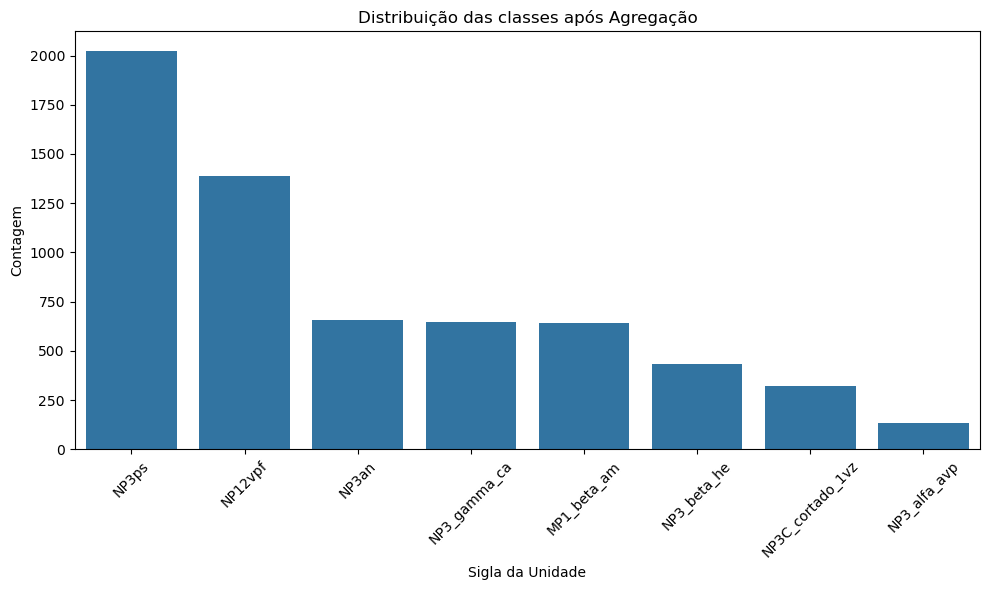

In [167]:
regras_agreg = {
    #Junção das classes do COMPLEXO PASSO FEIO (NP12vpf)
    'NP12vpfc': 'NP12vpf', 
    'NP12vpfm': 'NP12vpf',   
    
    # Junção das classes do Grupo Santa Bárbara (NP3ps)
     'NP3sl': 'NP3ps', 
     'NP3sf': 'NP3ps',
     
 }

# Criar nova coluna com classes agregadas
df['SIGLA_AGG'] = df['SIGLA_UNID'].replace(regras_agreg)

contagem_dos_locais = df['SIGLA_AGG'].value_counts()
print(contagem_dos_locais)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))  
sns.barplot(x=contagem_dos_locais.index, y=contagem_dos_locais.values)

# Adicionar títulos e formatação
plt.title('Distribuição das classes após Agregação')
plt.xlabel('Sigla da Unidade')
plt.ylabel('Contagem')
plt.xticks(rotation=45)  # Rotaciona os rótulos para melhor legibilidade

# Mostrar o gráfico
plt.tight_layout() 
plt.show()

In [168]:
area_status = df.groupby('SIGLA_AGG')[['TC', 'Kperc', 'eU', 'eTh', 'MDT']].describe()
print(area_status)

                      TC                                                    \
                   count      mean       std       min       25%       50%   
SIGLA_AGG                                                                    
MP1_beta_am        639.0  0.501287  0.285977  0.000549  0.258482  0.500463   
NP12vpf           1386.0  0.497534  0.296170  0.000447  0.227187  0.503339   
NP3C_cortado_1vz   323.0  0.487520  0.284093  0.004327  0.252284  0.460667   
NP3_alfa_avp       132.0  0.523412  0.295286  0.007194  0.265876  0.524392   
NP3_beta_he        431.0  0.524860  0.293014  0.001415  0.287212  0.536575   
NP3_gamma_ca       646.0  0.505011  0.297782  0.000746  0.241469  0.494080   
NP3an              658.0  0.499369  0.278096  0.002206  0.250986  0.516477   
NP3ps             2022.0  0.498210  0.286626  0.000044  0.253194  0.493283   

                                       Kperc            ...       eTh  \
                       75%       max   count      mean  ...       75

### Visulaização espacial após a agregação das litologias

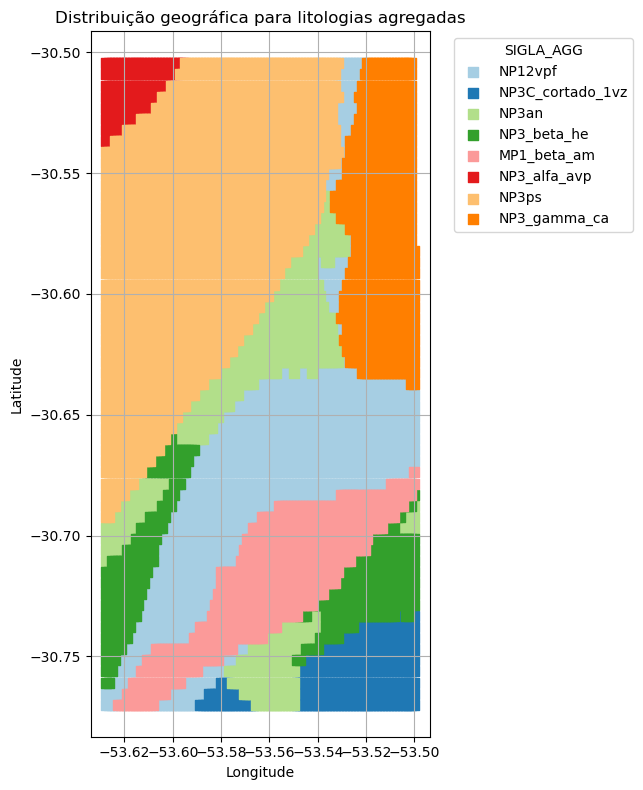

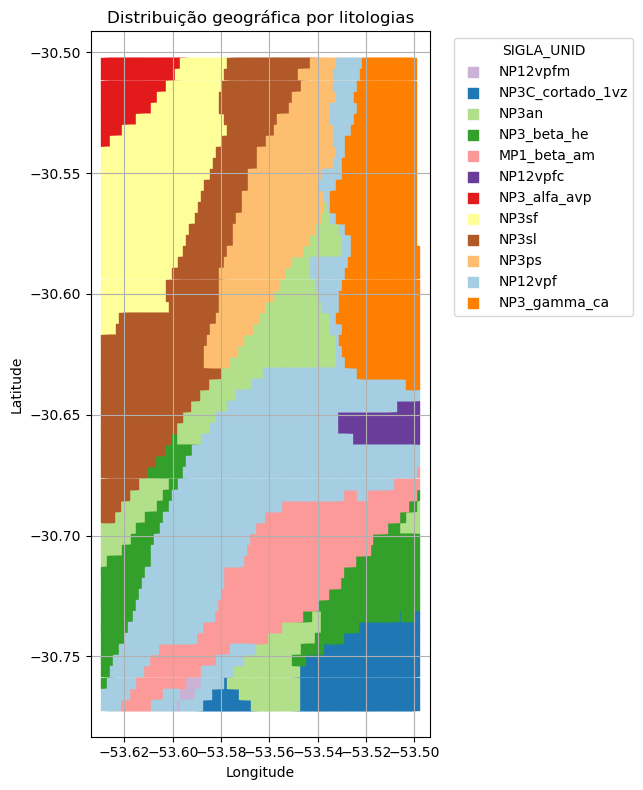

In [169]:
# Dicionário de cores único para todas as siglas
all_siglas = pd.concat([df['SIGLA_AGG'], df['SIGLA_UNID']]).unique()
cores = plt.cm.Paired(np.linspace(0, 1, len(all_siglas)))
color_dict = {sigla: cores[i] for i, sigla in enumerate(all_siglas)}

def plot_map(coluna, titulo):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot usando geopandas
    for sigla in df[coluna].unique():
        subset = df[df[coluna] == sigla]
        subset.plot(ax=ax, color=color_dict[sigla], label=sigla, markersize=45,marker='s')
    
    # Adicionar elementos do mapa
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(titulo)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=coluna)
    
    # Adicionar grid e ajustar layout
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Plotando os mapas
plot_map('SIGLA_AGG', 'Distribuição geográfica para litologias agregadas')
plot_map('SIGLA_UNID', 'Distribuição geográfica por litologias')

### Criando o modelo

In [170]:
# Definindo X e y (todas as amostras)
X = df.drop(['fid','SIGLA_AGG', 'COD_UNI_ES'], axis=1)  # Exclui target + IDs
y = df['SIGLA_AGG'] 

# Verificação global
print("Variáveis preditoras (X):", X.columns.tolist())
print("Variável target (y):", y.name)
print("\nShape de X (todas amostras):", X.shape)
print("Shape de y (todas amostras):", y.shape)
print("\nDistribuição original das classes:\n", y.value_counts())

Variáveis preditoras (X): ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'SIGLA_UNID', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'geometry', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']
Variável target (y): SIGLA_AGG

Shape de X (todas amostras): (6237, 24)
Shape de y (todas amostras): (6237,)

Distribuição original das classes:
 SIGLA_AGG
NP3ps               2022
NP12vpf             1386
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
Name: count, dtype: int64


In [171]:
# 1. Definindo features e target
features = [  'lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K',
            'Th_K', 'MDT', 'LS9_B6_SWIR', 'LS9_B5_NIR', 
            'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2',
            'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3'
            , 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']
target = 'SIGLA_AGG' 

# 2. Amostragem estratificada - garantindo 150 por classe no treino
train_data = pd.DataFrame()

for classe in df[target].unique():
    classe_df = df[df[target] == classe]
    
    if len(classe_df) >= 150:
        # Pegar 150 para treino e o resto vai para teste
        train_classe = classe_df.sample(n=150, random_state=42)
        train_data = pd.concat([train_data, train_classe])
    else:
        # Se menos que 150, usar 70% para treino
        train_classe, _ = train_test_split(classe_df, train_size=0.7, random_state=42)
        train_data = pd.concat([train_data, train_classe])

# 3. Conjunto de teste
test_data = df[~df.index.isin(train_data.index)]

# 4. Separar features e target
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# 5. Verificação
print(f"Treino: {len(X_train)} amostras")
print(f"Teste: {len(X_test)} amostras")
print("\nDistribuição no treino:")
print(y_train.value_counts())
print("\nDistribuição no teste:")
print(y_test.value_counts())

Treino: 1142 amostras
Teste: 5095 amostras

Distribuição no treino:
SIGLA_AGG
NP12vpf             150
NP3C_cortado_1vz    150
NP3an               150
NP3_beta_he         150
MP1_beta_am         150
NP3ps               150
NP3_gamma_ca        150
NP3_alfa_avp         92
Name: count, dtype: int64

Distribuição no teste:
SIGLA_AGG
NP3ps               1872
NP12vpf             1236
NP3an                508
NP3_gamma_ca         496
MP1_beta_am          489
NP3_beta_he          281
NP3C_cortado_1vz     173
NP3_alfa_avp          40
Name: count, dtype: int64


In [172]:
print("Features usadas no treino:", X_train.columns.tolist())

Features usadas no treino: ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']


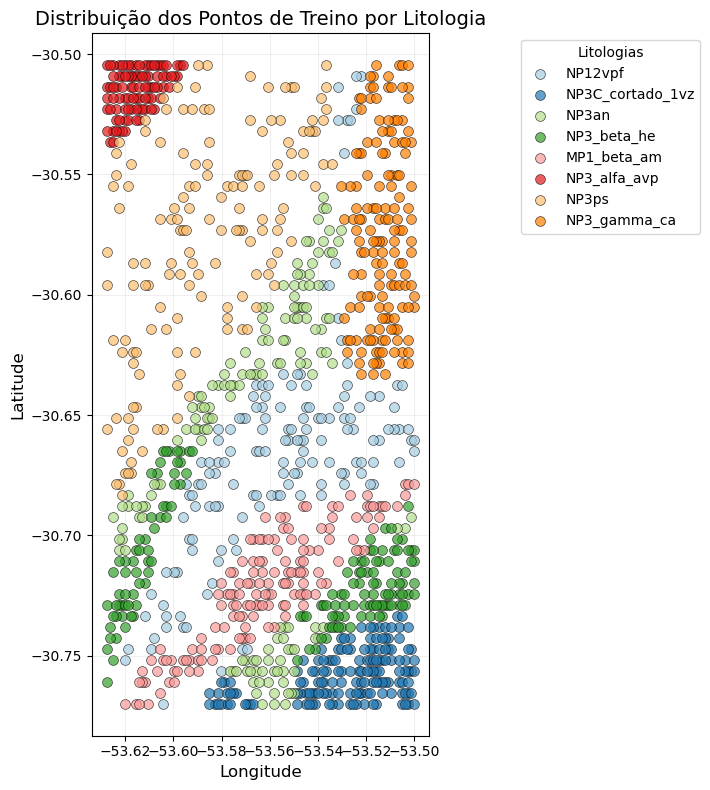

In [173]:
# Configuração das cores das litologias (compartilhada entre as células)
litologias_unicas = pd.concat([df['SIGLA_AGG'], df['SIGLA_UNID']]).unique()
cores = plt.cm.Paired(np.linspace(0, 1, len(litologias_unicas)))  # Paleta "Paired" do matplotlib
color_dict = {litologia: cores[i] for i, litologia in enumerate(litologias_unicas)}

# Visualização dos dados de treino - Versão otimizada para GeoDataFrame
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get current axis

# Usando plot do GeoDataFrame para melhor performance
for litologia in train_data[target].unique():
    subset = train_data[train_data[target] == litologia]
    subset.plot(
        ax=ax,
        color=color_dict[litologia],  # Mesma cor para cada litologia
        label=litologia, 
        markersize=50, 
        alpha=0.7,
        edgecolor='k',  
        linewidth=0.5
    )
    
plt.legend(bbox_to_anchor=(1.25, 1), title='Litologias', fontsize=10)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Distribuição dos Pontos de Treino por Litologia', fontsize=14)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

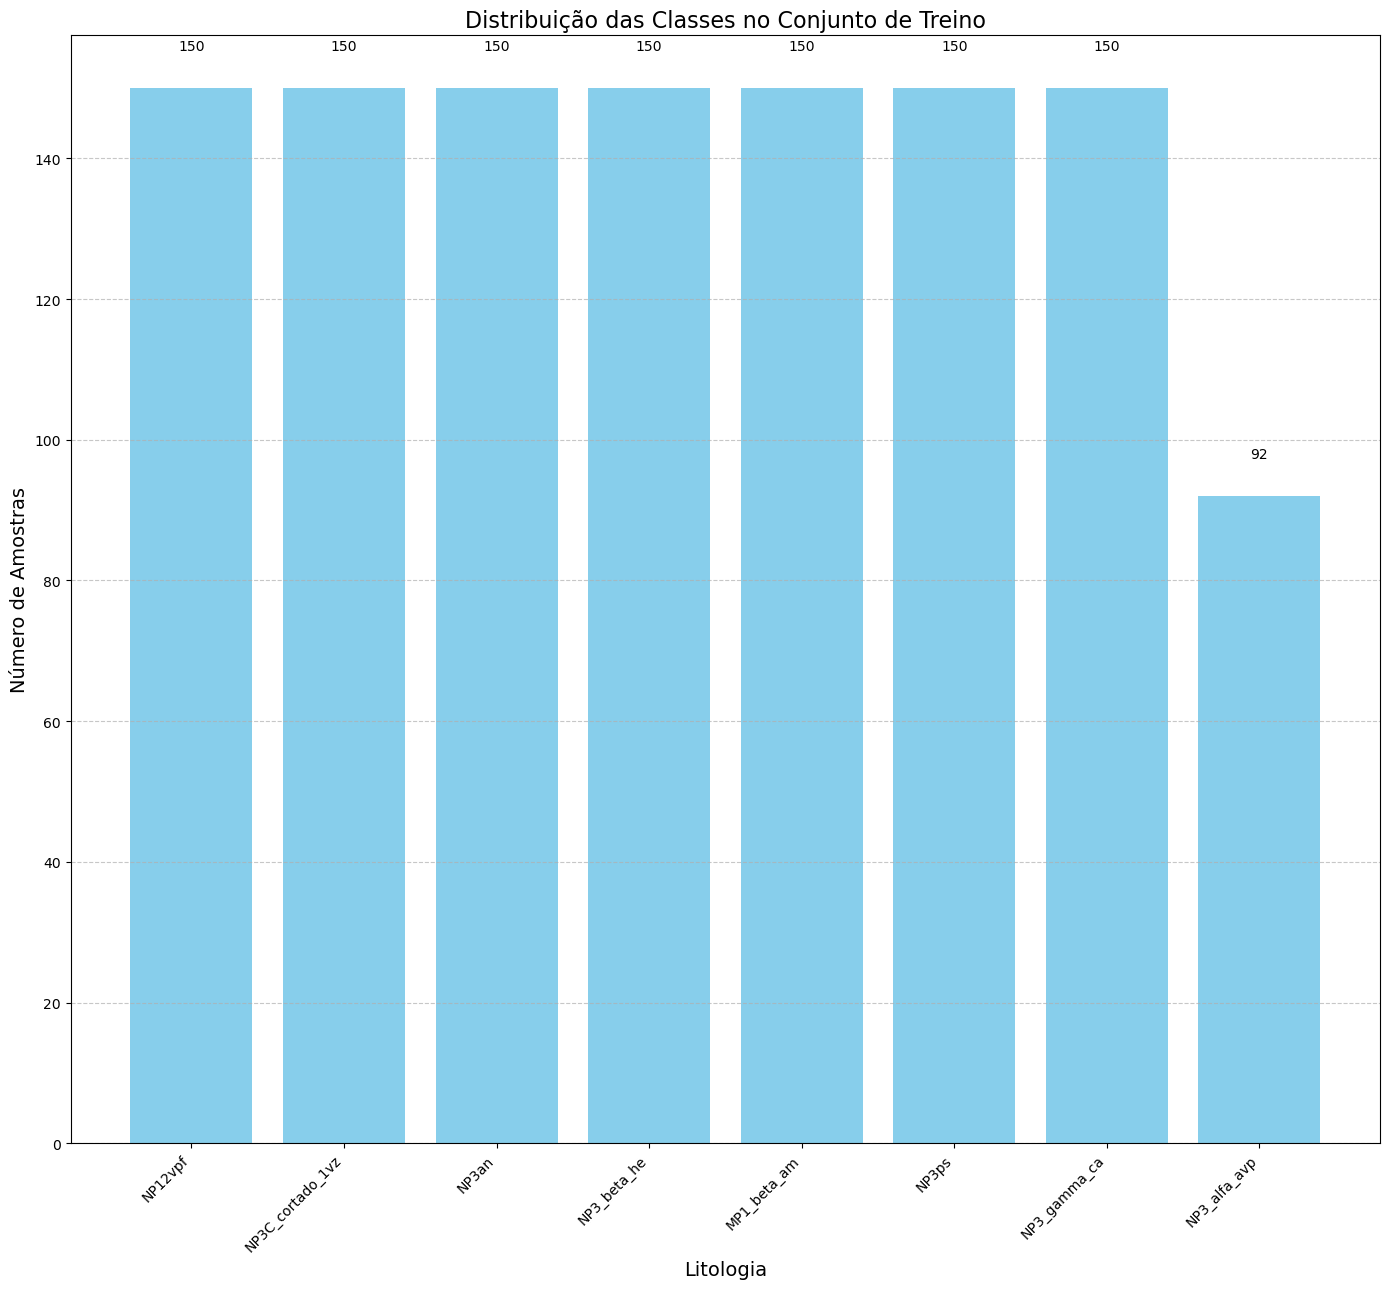

In [174]:
# Preparar os dados
class_dist = y_train.value_counts().reset_index()
class_dist.columns = ['Litologia', 'Quantidade']
class_dist = class_dist.sort_values('Quantidade', ascending=False)

# Criar figura
plt.figure(figsize=(14, 13))

#  Gráfico de barras simples (matplotlib)
plt.bar(class_dist['Litologia'], class_dist['Quantidade'], color='skyblue')
plt.title('Distribuição das Classes no Conjunto de Treino', fontsize=16)
plt.xlabel('Litologia', fontsize=14)
plt.ylabel('Número de Amostras', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar valores nas barras
for i, value in enumerate(class_dist['Quantidade']):
    plt.text(i, value + 5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [175]:
df_treino = train_data

# Sava em CSV
df_treino.to_csv('treino_PFeio_AGG.csv', index=False)

print('CSV salvo com sucesso')

CSV salvo com sucesso


In [176]:
feature_names = X_train.columns.tolist()  # Nomes antes do SMOTE

### SMOTE

In [177]:

X_train_smt, y_train_smt = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42).fit_resample(X_train, y_train)

In [178]:
print("Features após SMOTE:", X_train_smt.columns.tolist())
print("Features originais:", feature_names)
assert X_train_smt.columns.tolist() == feature_names, "SMOTE alterou a ordem das features!"

Features após SMOTE: ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']
Features originais: ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']


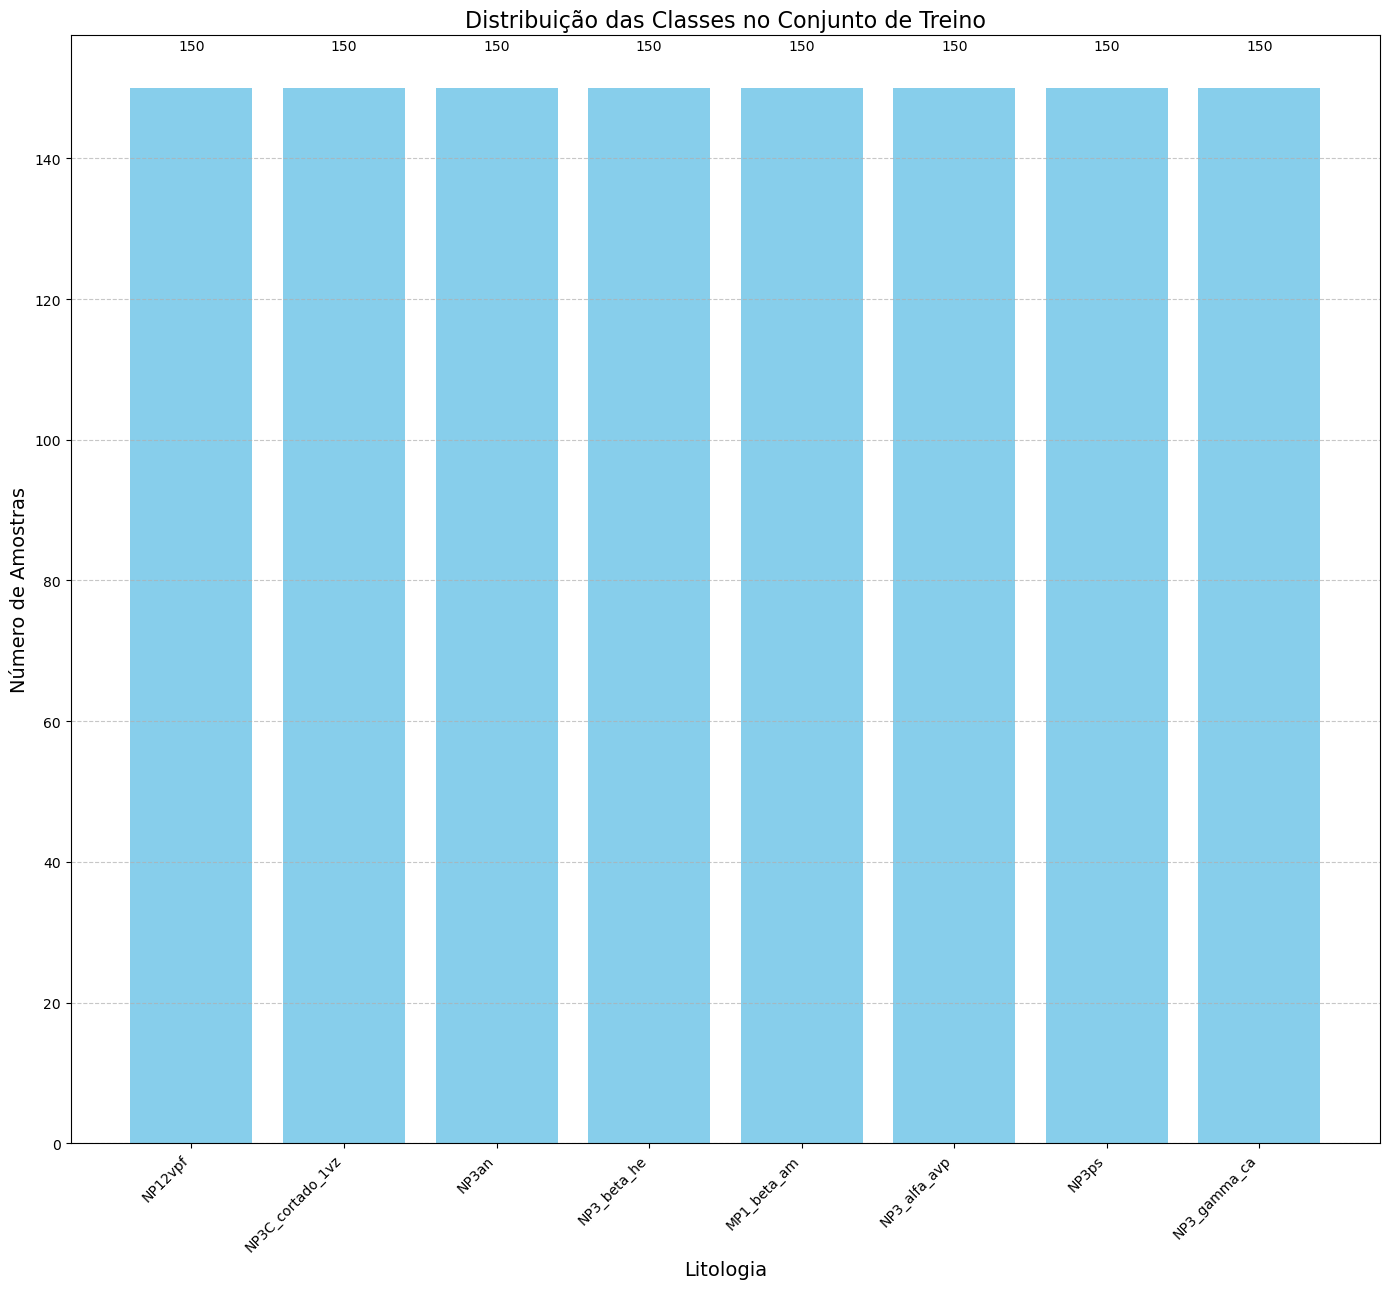

In [179]:
class_dist = y_train_smt.value_counts().reset_index()
class_dist.columns = ['Litologia', 'Quantidade']
class_dist = class_dist.sort_values('Quantidade', ascending=False)

# Criar figura
plt.figure(figsize=(14, 13))

# Gráfico de barras simples (matplotlib)
plt.bar(class_dist['Litologia'], class_dist['Quantidade'], color='skyblue')
plt.title('Distribuição das Classes no Conjunto de Treino', fontsize=16)
plt.xlabel('Litologia', fontsize=14)
plt.ylabel('Número de Amostras', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar valores nas barras
for i, value in enumerate(class_dist['Quantidade']):
    plt.text(i, value + 5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()



### Verificaçção dos dados após o SMOTE

In [180]:

X_pred = df[features].copy() 

# Verifique valores nulos
print("Valores nulos por feature:")
print(X_pred.isnull().sum())



Valores nulos por feature:
lon                   0
lat                   0
TC                    0
Kperc                 0
eU                    0
eTh                   0
U_Th                  0
U_K                   0
Th_K                  0
MDT                   0
LS9_B6_SWIR           0
LS9_B5_NIR            0
LS9_B4_Red            0
LS9_B3_Green          0
LS9_B2_Blue           0
LS9_B7_SWIR2          0
LS9_RGB_Falsacor_1    0
LS9_RGB_Falsacor_2    0
LS9_RGB_Falsacor_3    0
NDVI                  0
Ratio_B5_B4           0
Ratio_B7_B6           0
dtype: int64


In [181]:
missing = [f for f in features if f not in df.columns]
if missing:
    print(f"ERRO CRÍTICO: Features faltando: {missing}")
    print("Soluções possíveis:")
    print("1. Adicione as features faltantes ao DataFrame")
    print("2. Retreine o modelo sem essas features")
    raise ValueError("Features inconsistentes")
else:
    print("Todas as features presentes - pode prosseguir com a predição")

Todas as features presentes - pode prosseguir com a predição


In [182]:
# Pipeline com pré-processamento
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Menos sensível a outliers que StandardScaler
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced_subsample'  # Versão melhorada para RF
    ))
])

# Grade de parâmetros expandida
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt']  # Adicionado controle de features
}

# Usando validação cruzada estratificada e balanced_accuracy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='balanced_accuracy',  # Melhor para classes desbalanceadas
    n_jobs=-1,
    verbose=2  
)

grid_search.fit(X_train_smt, y_train_smt)  # Usando dados balanceados

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced_subsample',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='balanced_accuracy', verbose=2)

In [183]:

# OBTER FEATURES REAIS USADAS NO TREINO

features_reais = grid_search.best_estimator_.named_steps['scaler'].feature_names_in_
print("Features usadas pelo modelo:", features_reais)


# PREPARAR DADOS PARA PREDIÇÃO

# Verificar se todas as features estão no DataFrame
missing = [f for f in features_reais if f not in df.columns]
if missing:
    raise ValueError(f"Features faltando no DataFrame: {missing}")

X_pred = df[features_reais].copy()
X_pred.fillna(X_pred.median(), inplace=True)  # Tratar valores nulos


# 3. FAZER PREDIÇÕES

df['RF_Prediction'] = grid_search.best_estimator_.predict(X_pred)
print("Predições adicionadas ao DataFrame!")

Features usadas pelo modelo: ['lon' 'lat' 'TC' 'Kperc' 'eU' 'eTh' 'U_Th' 'U_K' 'Th_K' 'MDT'
 'LS9_B6_SWIR' 'LS9_B5_NIR' 'LS9_B4_Red' 'LS9_B3_Green' 'LS9_B2_Blue'
 'LS9_B7_SWIR2' 'LS9_RGB_Falsacor_1' 'LS9_RGB_Falsacor_2'
 'LS9_RGB_Falsacor_3' 'NDVI' 'Ratio_B5_B4' 'Ratio_B7_B6']
Predições adicionadas ao DataFrame!


In [184]:
best_model = grid_search.best_estimator_
df['RF_Prediction'] = best_model.predict(X_pred)

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)  
y_proba = best_model.predict_proba(X_test)  

# Métricas básicas
print(f"Melhores parâmetros: {grid_search.best_params_}\n")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Acurácia Balanceada: {balanced_accuracy_score(y_test, y_pred):.4f}\n")
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

Melhores parâmetros: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Acurácia: 0.7845
Acurácia Balanceada: 0.8214

Relatório de Classificação:
                   precision    recall  f1-score   support

     MP1_beta_am     0.5692    0.7321    0.6404       489
         NP12vpf     0.8709    0.5947    0.7067      1236
NP3C_cortado_1vz     0.7746    0.9538    0.8549       173
    NP3_alfa_avp     0.7500    0.9750    0.8478        40
     NP3_beta_he     0.4365    0.8078    0.5668       281
    NP3_gamma_ca     0.8330    0.9859    0.9030       496
           NP3an     0.5974    0.6339    0.6151       508
           NP3ps     0.9714    0.8878    0.9277      1872

        accuracy                         0.7845      5095
       macro avg     0.7254    0.8214    0.7578      5095
    weighted avg     0.8197    0.7845    0.7900      5095



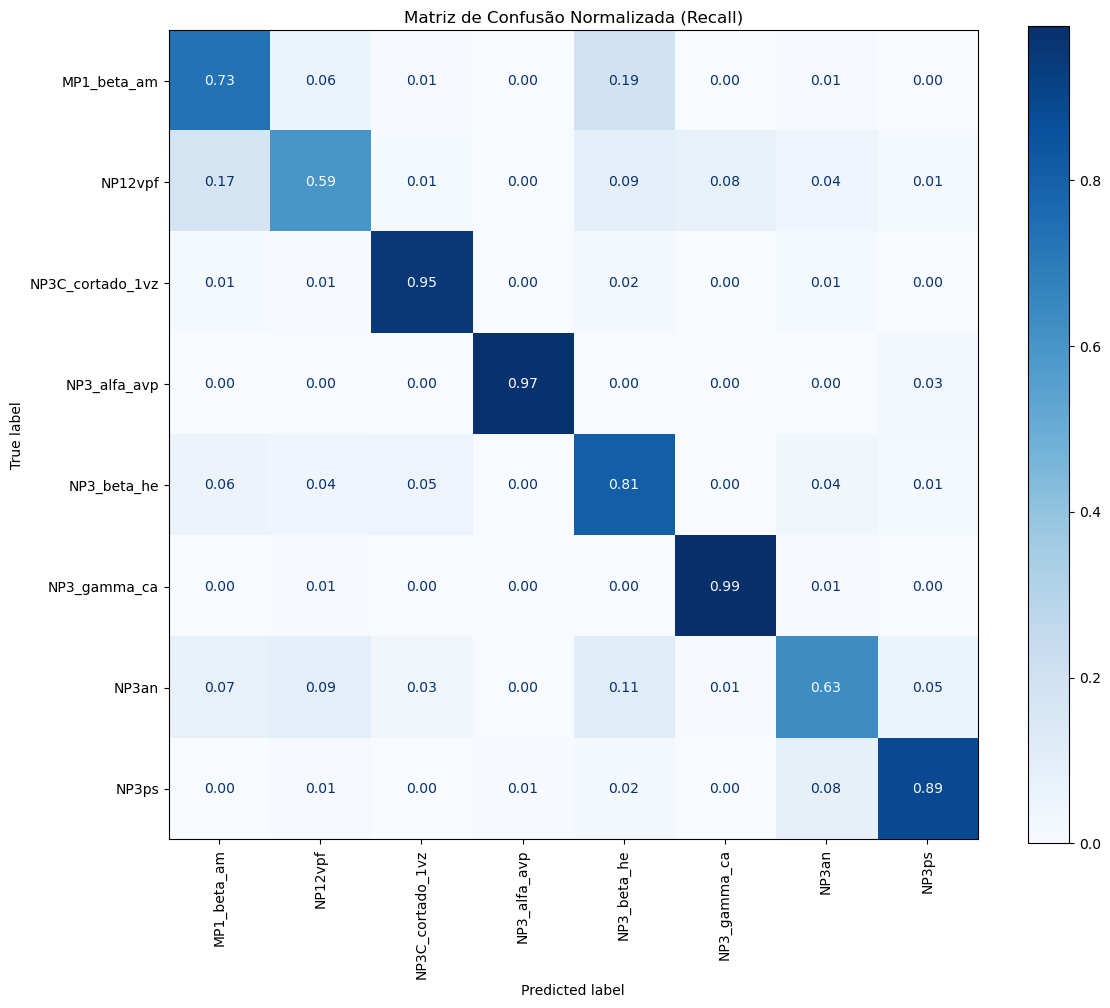

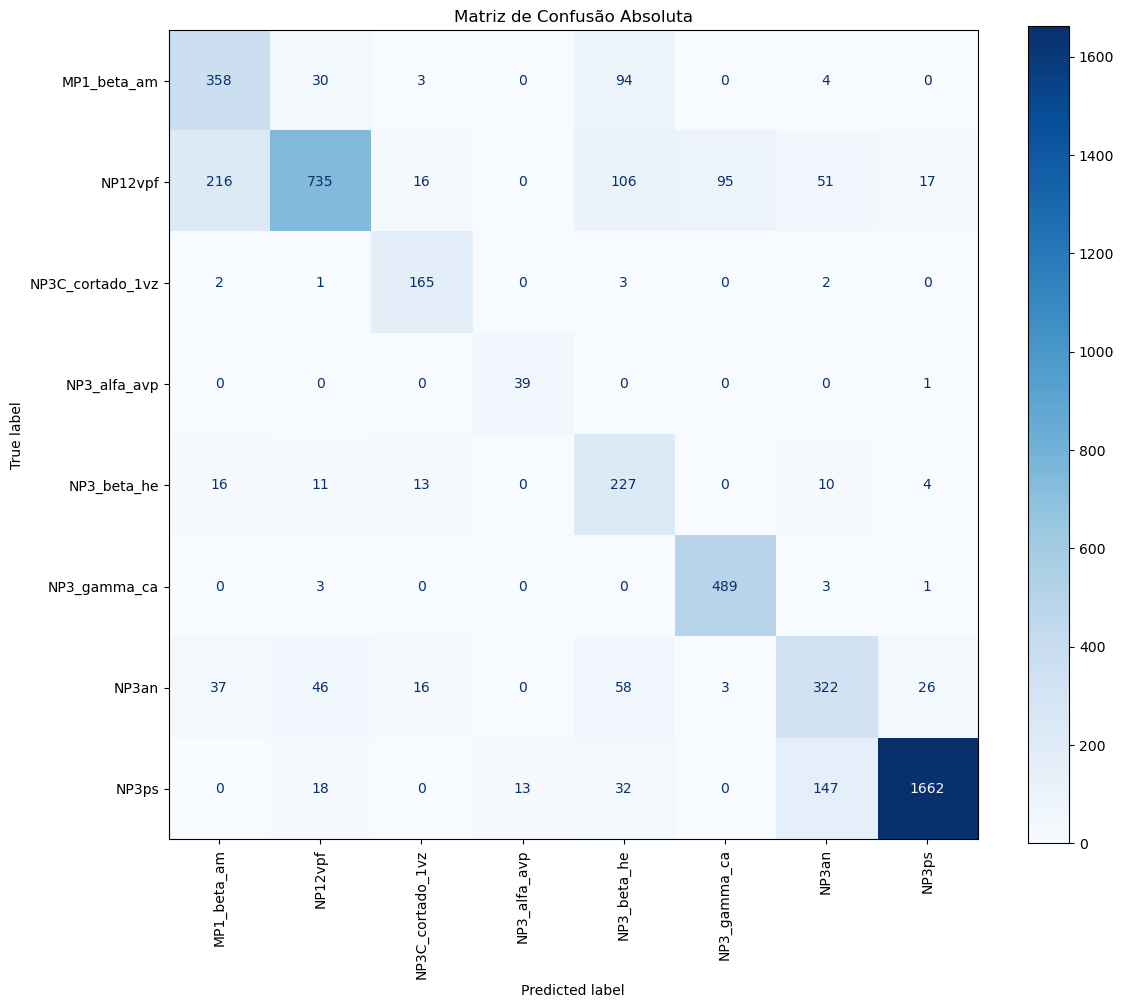

In [185]:
# Matriz de confusão normalizada por linha (recall)
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize='true',
    cmap='Blues',
    ax=ax,
    values_format='.2f',
    xticks_rotation=90
)
plt.title('Matriz de Confusão Normalizada (Recall)')
plt.tight_layout()
plt.show()

# Matriz de confusão absoluta
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap='Blues',
    ax=ax,
    values_format='d',
    xticks_rotation=90
)
plt.title('Matriz de Confusão Absoluta')
plt.tight_layout()
plt.show()

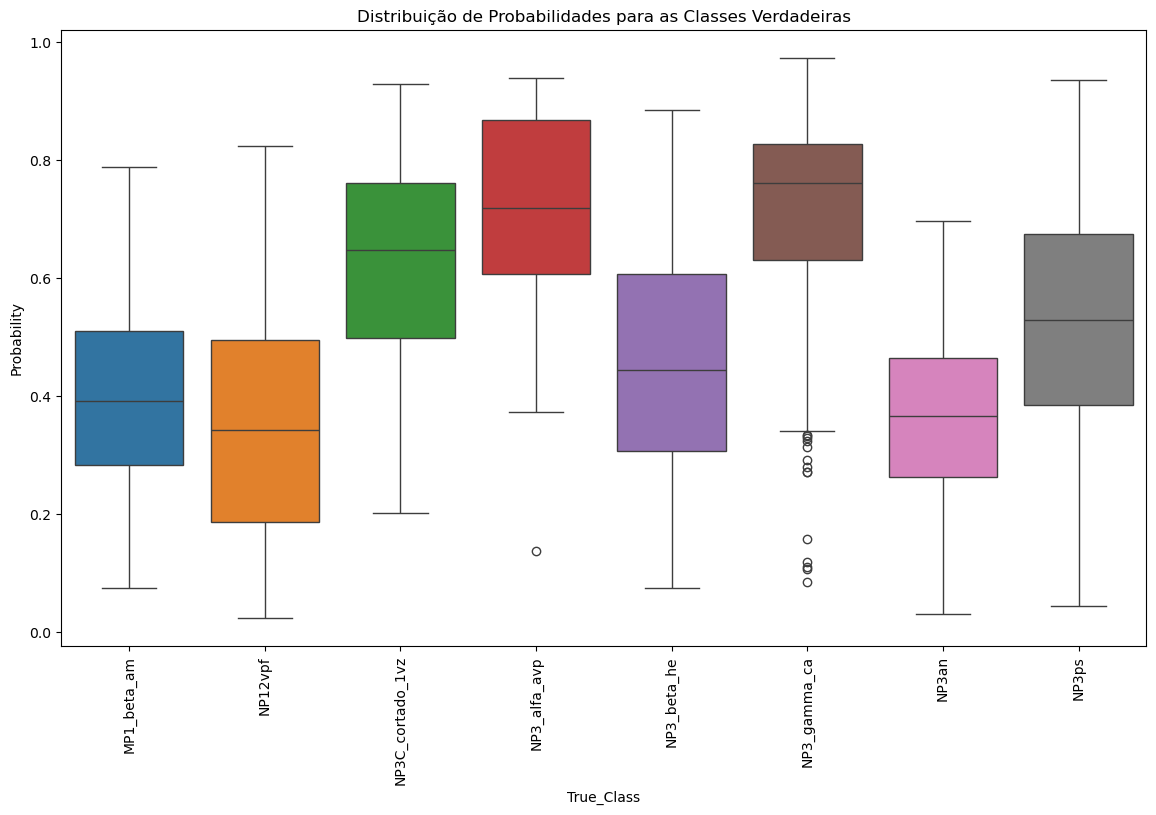

In [186]:
# Usando o modelo otimizado que você treinou
best_model = grid_search.best_estimator_  

# Obter as probabilidades e previsões
y_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

# DataFrame com probabilidades:
# Use best_model.classes_ para os nomes das colunas
prob_df = pd.DataFrame(y_proba, columns=best_model.classes_)
prob_df['True_Class'] = y_test.reset_index(drop=True)
prob_df['Predicted_Class'] = y_pred

# Visualização
melted_probs = prob_df.melt(id_vars=['True_Class', 'Predicted_Class'], 
                           var_name='Class', 
                           value_name='Probability')

plt.figure(figsize=(14, 8))
sns.boxplot(x='True_Class', y='Probability', hue='Class', 
            data=melted_probs[melted_probs['Class'] == melted_probs['True_Class']])
plt.title('Distribuição de Probabilidades para as Classes Verdadeiras')
plt.xticks(rotation=90)
plt.legend([], [], frameon=False)
plt.show()

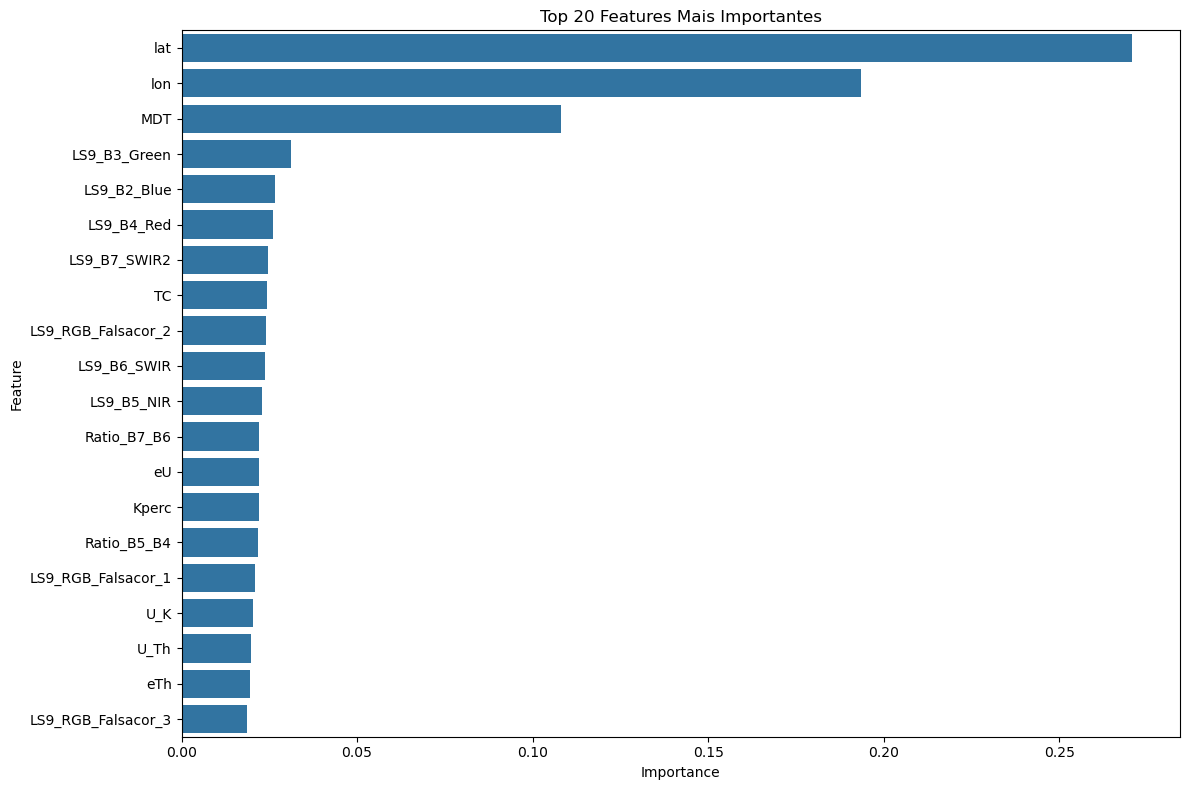

In [187]:
# Extrair importância das features do melhor modelo do GridSearch
best_model = grid_search.best_estimator_

# Acessar o classificador dentro do pipeline
importances = best_model.named_steps['classifier'].feature_importances_
features = features_reais  # Usando as features que foram realmente usadas no treino

feature_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_imp = feature_imp.sort_values('Importance', ascending=False)

# Plotar top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
plt.title('Top 20 Features Mais Importantes')
plt.tight_layout()
plt.show()

# Salvar importância para análise
feature_imp.to_csv('feature_importance.csv', index=False)

In [188]:
# Ajuste de thresholds por classe
best_model = grid_search.best_estimator_
rf_classifier = best_model.named_steps['classifier']  # Acessa o RandomForest dentro do pipeline

thresholds = {}
for i, cls in enumerate(rf_classifier.classes_):
    precision, recall, thresh = precision_recall_curve(y_test == cls, y_proba[:, i])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1)
    thresholds[cls] = thresh[optimal_idx]

# Aplicar novos thresholds
y_pred_adj = np.array([rf_classifier.classes_[i] for i in np.argmax(
    y_proba > np.array([thresholds[cls] for cls in rf_classifier.classes_]), axis=1)])

print("\nRelatório com Thresholds Ajustados:\n", classification_report(y_test, y_pred_adj))


Relatório com Thresholds Ajustados:
                   precision    recall  f1-score   support

     MP1_beta_am       0.41      0.88      0.56       489
         NP12vpf       0.79      0.62      0.69      1236
NP3C_cortado_1vz       0.93      0.87      0.90       173
    NP3_alfa_avp       0.89      0.85      0.87        40
     NP3_beta_he       0.61      0.58      0.59       281
    NP3_gamma_ca       0.91      0.94      0.93       496
           NP3an       0.60      0.56      0.58       508
           NP3ps       0.97      0.84      0.90      1872

        accuracy                           0.76      5095
       macro avg       0.76      0.77      0.75      5095
    weighted avg       0.81      0.76      0.77      5095



In [189]:
# 1. Ve que features usedforam usados no treino (scaler)
features_reais = grid_search.best_estimator_.named_steps['scaler'].feature_names_in_

# 2. Preparando os dados preditos
X_pred = df[features_reais].copy()
X_pred.fillna(X_pred.median(), inplace=True)  # Handle missing values same as training

# 3. Gerando as predições em cima do pipeline (scaler + classifier)
df['RF_Prediction'] = grid_search.best_estimator_.predict(X_pred)

# 4. Verificar os resultados
print("Predições geradas com sucesso!")
print("Features usadas:", features_reais.tolist())
print("\nDistribuição das classes preditas:")
print(df['RF_Prediction'].value_counts())

Predições geradas com sucesso!
Features usadas: ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']

Distribuição das classes preditas:
RF_Prediction
NP3ps               1861
NP12vpf              994
MP1_beta_am          779
NP3_gamma_ca         737
NP3an                689
NP3_beta_he          670
NP3C_cortado_1vz     363
NP3_alfa_avp         144
Name: count, dtype: int64


C:\Users\Matias\AppData\Local\Temp\ipykernel_16632\98887884.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file("predicoes_litologia_rf.shp")
c:\Users\Matias\anaconda3\envs\myenv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'LS9_B6_SWIR' to 'LS9_B6_SWI'
  ogr_write(
c:\Users\Matias\anaconda3\envs\myenv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'LS9_B3_Green' to 'LS9_B3_Gre'
  ogr_write(
c:\Users\Matias\anaconda3\envs\myenv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'LS9_B2_Blue' to 'LS9_B2_Blu'
  ogr_write(
c:\Users\Matias\anaconda3\envs\myenv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'LS9_B7_SWIR2' to 'LS9_B7_SWI'
  ogr_write(
c:\Users\Matias\anaconda3\envs\myenv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field na

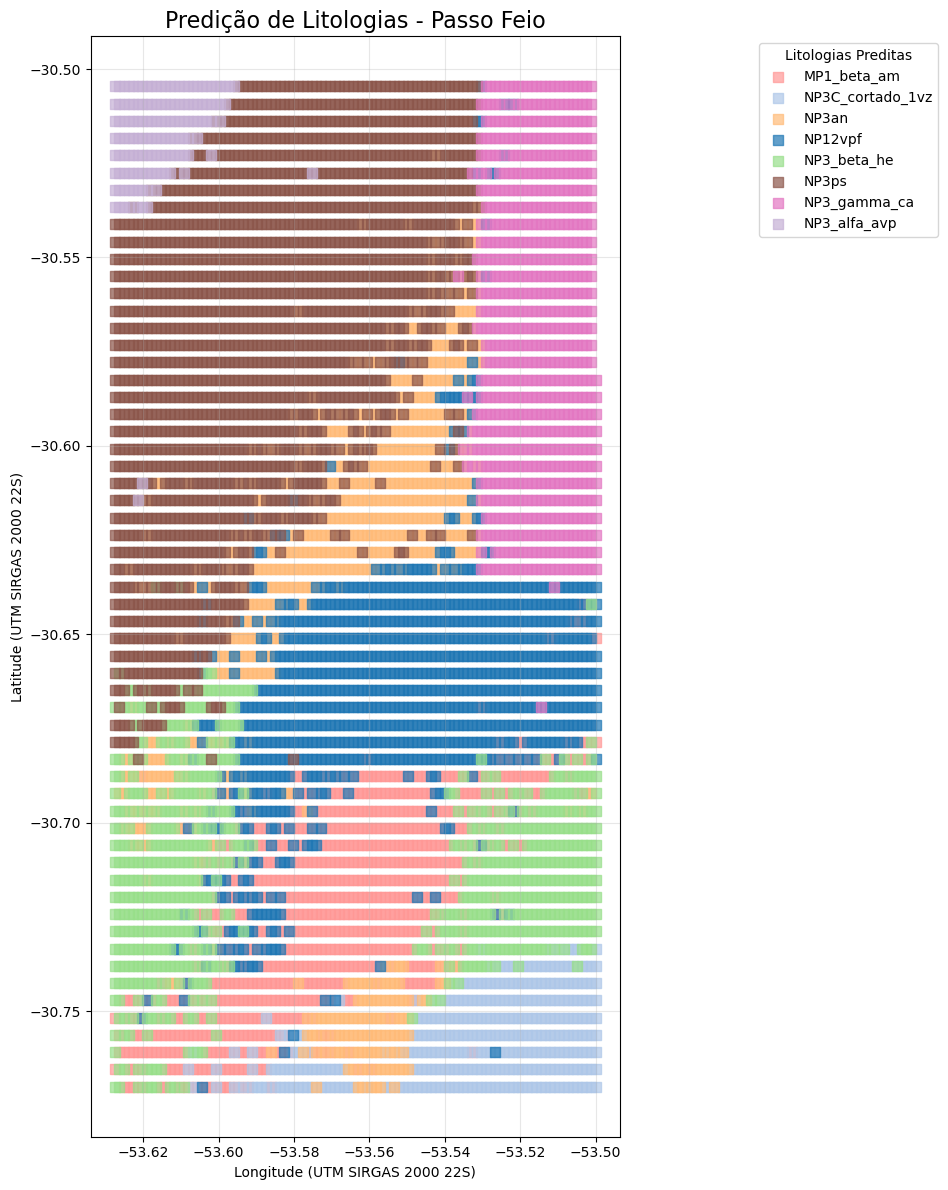

In [190]:
# 1. Configurar cores
litologias_unicas = pd.concat([df['SIGLA_AGG'], df['SIGLA_UNID']]).unique()
cores = plt.cm.tab20(np.linspace(0, 1, len(litologias_unicas)))
color_dict = {litologia: cores[i] for i, litologia in enumerate(litologias_unicas)}

# 2. Criar figura
fig, ax = plt.subplots(figsize=(15, 12))

# 3. Plotar cada litologia
for litologia in df['RF_Prediction'].unique():
    subset = df[df['RF_Prediction'] == litologia]
    subset.plot(ax=ax, color=color_dict[litologia], marker='s',
               label=litologia, markersize=45, alpha=0.7)

# 4. Elementos do mapa

ax.set_title('Predição de Litologias - Passo Feio', fontsize=16)
ax.set_xlabel('Longitude (UTM SIRGAS 2000 22S)')
ax.set_ylabel('Latitude (UTM SIRGAS 2000 22S)')
plt.legend(bbox_to_anchor=(1.25, 1), title='Litologias Preditas')
plt.grid(alpha=0.3)
plt.tight_layout()

# 5. Salvar
df.to_file("predicoes_litologia_rf.shp")
plt.savefig('mapa_predicoes_rf.tif', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
best_model = grid_search.best_estimator_


X_para_prever = df[features_reais] # Seleciona as features do GDF completo
gdf_para_plotar = df             # Usa o GDF completo para plotar


# 1. Prever as probabilidades para cada classe
#    O método predict_proba retorna um array onde cada linha é um ponto de dado
#    e cada coluna é a probabilidade daquele ponto pertencer a uma classe específica.
probabilities = best_model.predict_proba(X_para_prever)

# 2. Calcular a confiança (probabilidade máxima para cada ponto)
#  encontra o maior valor em cada linha (maior prob.)
confidence_scores = np.max(probabilities, axis=1)

# 3. Adicionar a coluna de confiança ao GeoDataFrame que será plotado
#    Certifique-se que 'gdf_para_plotar' é o GeoDataFrame correto (com a coluna geometry)
gdf_para_plotar['RF_Confidence'] = confidence_scores

# (Opcional) Você pode também adicionar a classe predita, se quiser usar depois
#gdf_para_plotar['RF_Prediction'] = best_model.predict(X_para_prever)

print(f"Coluna 'RF_Confidence' adicionada ao GeoDataFrame.")
print(gdf_para_plotar[['geometry', 'RF_Confidence']].head()) # Verifica

Coluna 'RF_Confidence' adicionada ao GeoDataFrame.
                  geometry  RF_Confidence
0     POINT (-53.6 -30.77)       0.330237
1   POINT (-53.598 -30.77)       0.405047
2   POINT (-53.597 -30.77)       0.356980
3   POINT (-53.596 -30.77)       0.348422
4  POINT (-53.598 -30.765)       0.450584


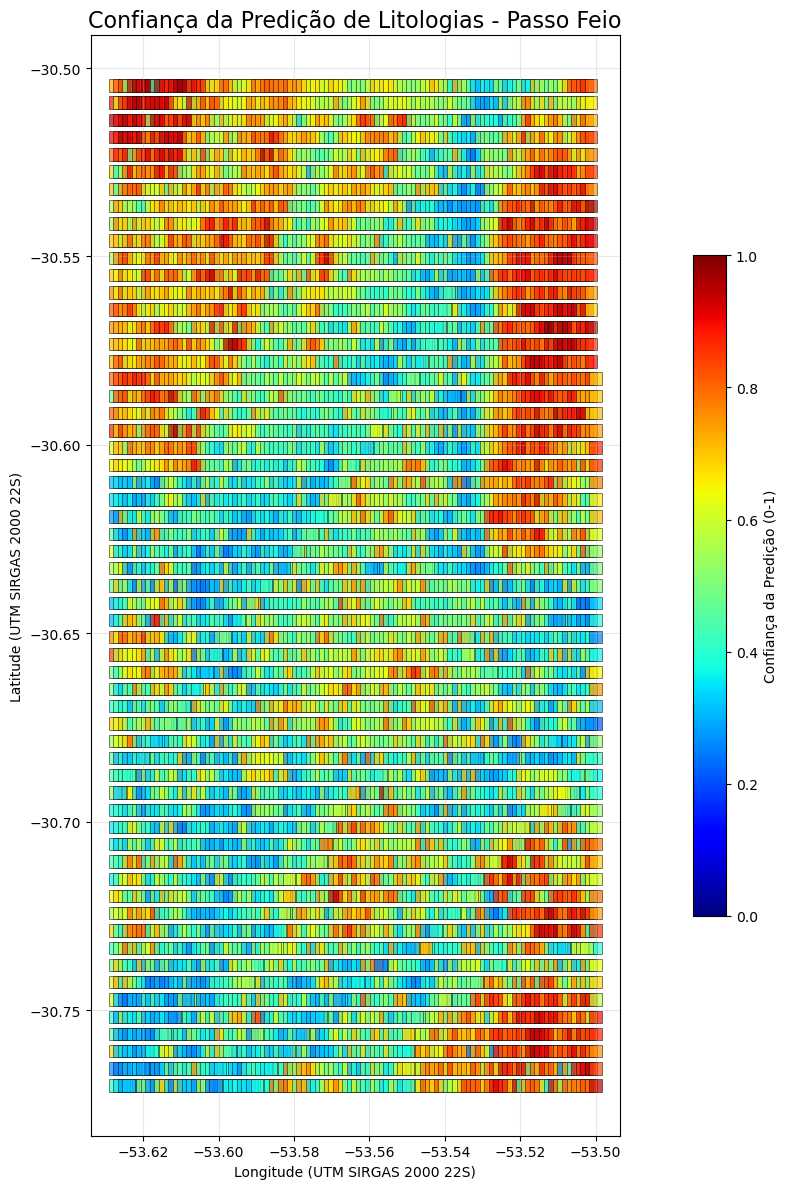

In [192]:
# 1. Configurar a figura
fig, ax = plt.subplots(figsize=(15, 12))

# 2. Plotar os pontos usando o GeoDataFrame 

scatter_plot = gdf_para_plotar.plot(
    ax=ax,
    column='RF_Confidence',  
    cmap='jet',          # Gradiente de cores
    marker='s',              # Marcador quadrado
    markersize=80,           # Tamanho dos pontos
    alpha=0.7,               # Transparência
    legend=True,             # Mostrar barra de cores
    vmin=0, vmax=1,          # Limites da escala de confiança (0 a 1)
    edgecolor='k',           # Borda preta
    linewidth=0.5,           # Espessura da borda
    # Ajuste a legenda diretamente aqui para melhor controle
    legend_kwds={'label': "Confiança da Predição (0-1)",
                 'orientation': "vertical", # Ou 'horizontal'
                 'shrink': 0.6} # Ajuste o tamanho da barra de cores
)

# 3. Elementos do mapa
ax.set_title('Confiança da Predição de Litologias - Passo Feio', fontsize=16)
ax.set_xlabel('Longitude (UTM SIRGAS 2000 22S)')
ax.set_ylabel('Latitude (UTM SIRGAS 2000 22S)')

# 4. Barra de cores 
plt.grid(alpha=0.3)
plt.tight_layout() # Ajusta o layout para evitar sobreposição

# 5. Salvar
plt.savefig('mapa_confianca_rf.tif', dpi=300, bbox_inches='tight')
plt.show()

Adicionando colunas de probabilidade ao GeoDataFrame:
 - Coluna 'Prob_MP1_beta_am' adicionada.
 - Coluna 'Prob_NP12vpf' adicionada.
 - Coluna 'Prob_NP3C_cortado_1vz' adicionada.
 - Coluna 'Prob_NP3_alfa_avp' adicionada.
 - Coluna 'Prob_NP3_beta_he' adicionada.
 - Coluna 'Prob_NP3_gamma_ca' adicionada.
 - Coluna 'Prob_NP3an' adicionada.
 - Coluna 'Prob_NP3ps' adicionada.

GeoDataFrame atualizado com probabilidades:
                  geometry  Prob_MP1_beta_am  Prob_NP12vpf  \
0     POINT (-53.6 -30.77)          0.330237      0.099655   
1   POINT (-53.598 -30.77)          0.405047      0.070032   
2   POINT (-53.597 -30.77)          0.356980      0.206464   
3   POINT (-53.596 -30.77)          0.304979      0.066286   
4  POINT (-53.598 -30.765)          0.450584      0.056555   

   Prob_NP3C_cortado_1vz  Prob_NP3_alfa_avp  Prob_NP3_beta_he  \
0               0.185748           0.024076          0.107801   
1               0.177200           0.000866          0.081016   
2             

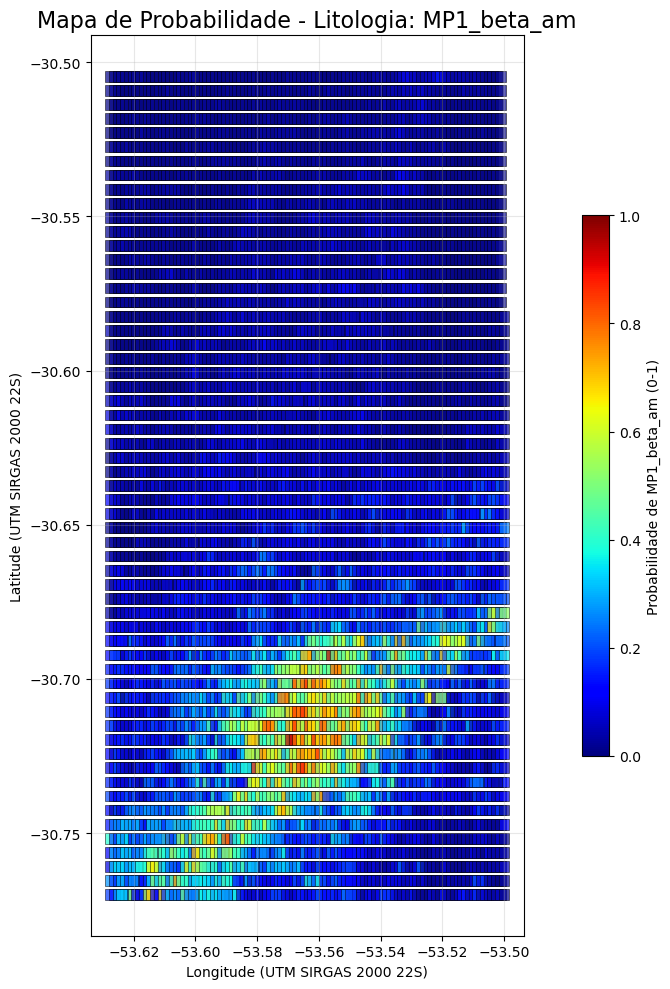

 - Exibindo mapa para: NP12vpf


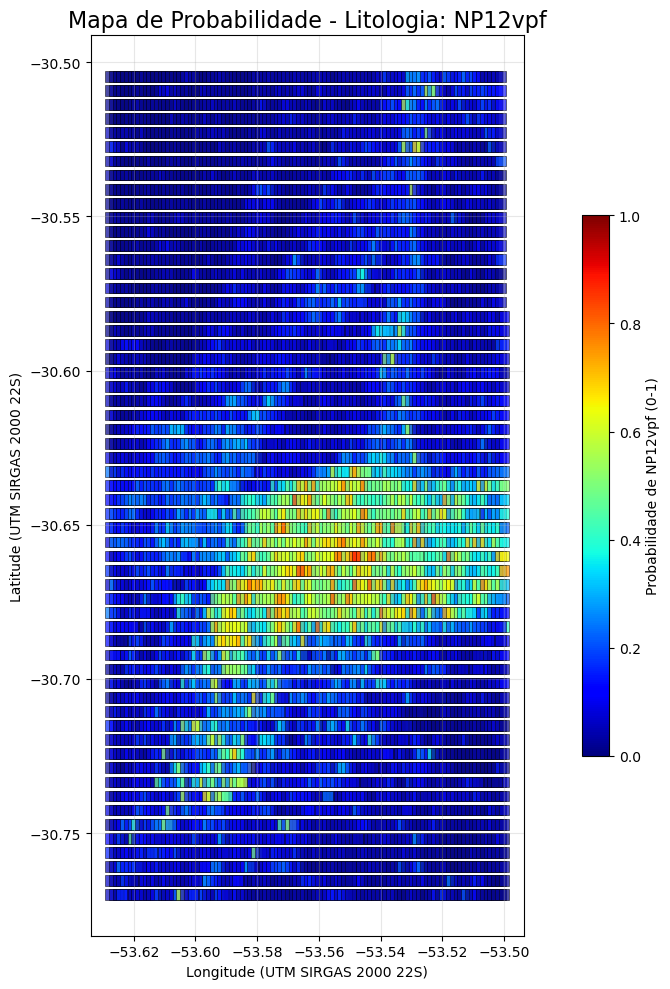

 - Exibindo mapa para: NP3C_cortado_1vz


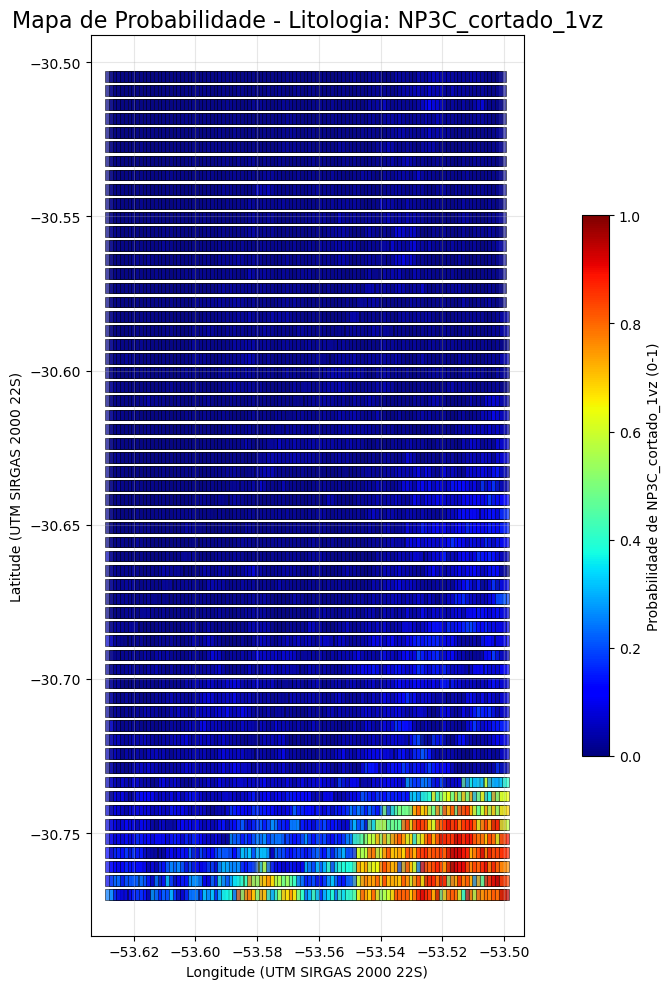

 - Exibindo mapa para: NP3_alfa_avp


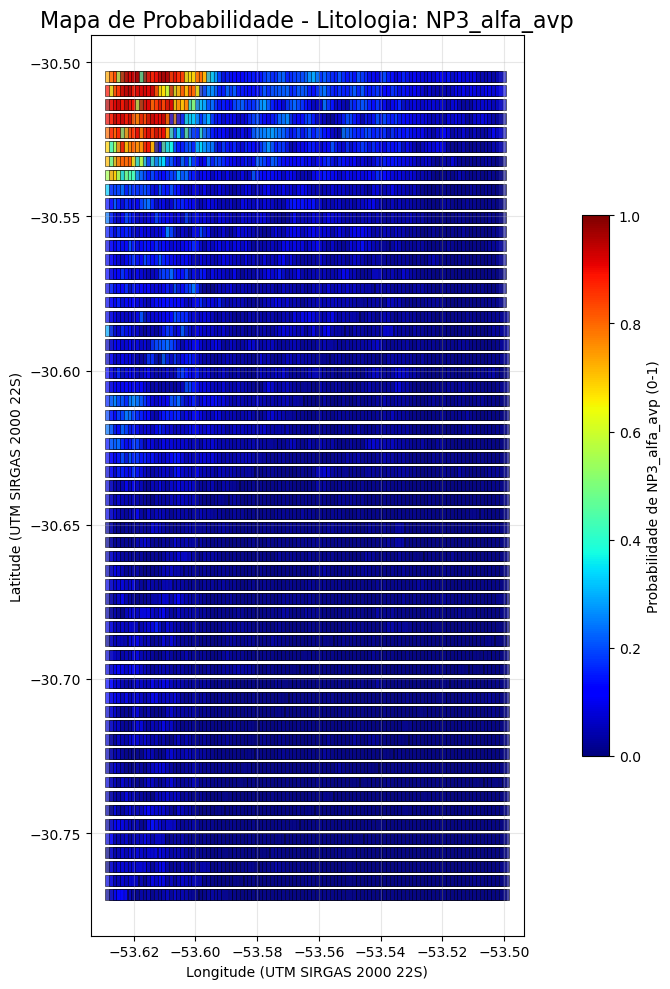

 - Exibindo mapa para: NP3_beta_he


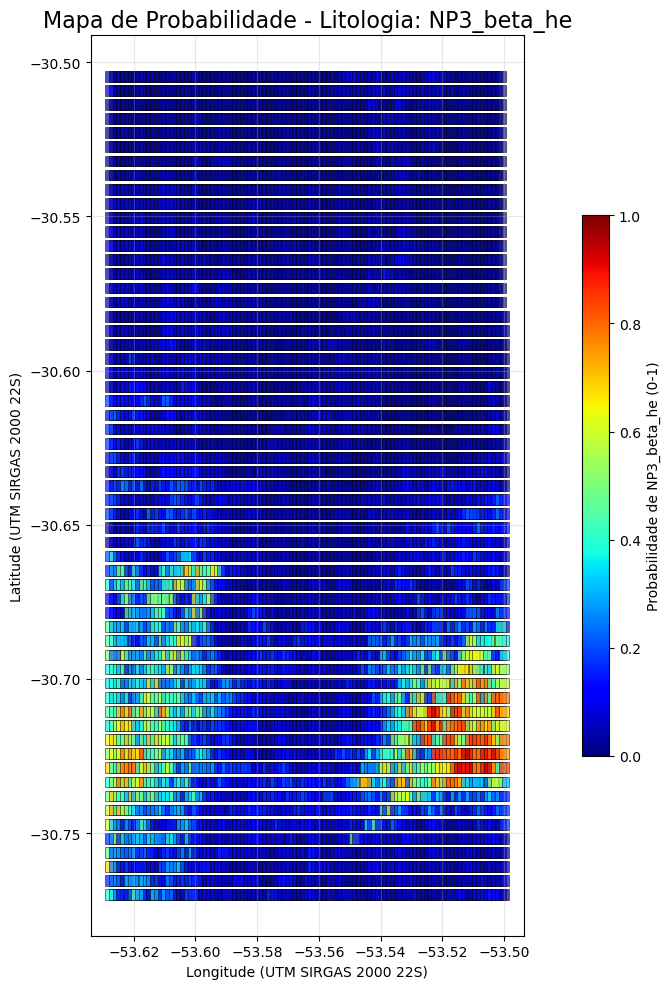

 - Exibindo mapa para: NP3_gamma_ca


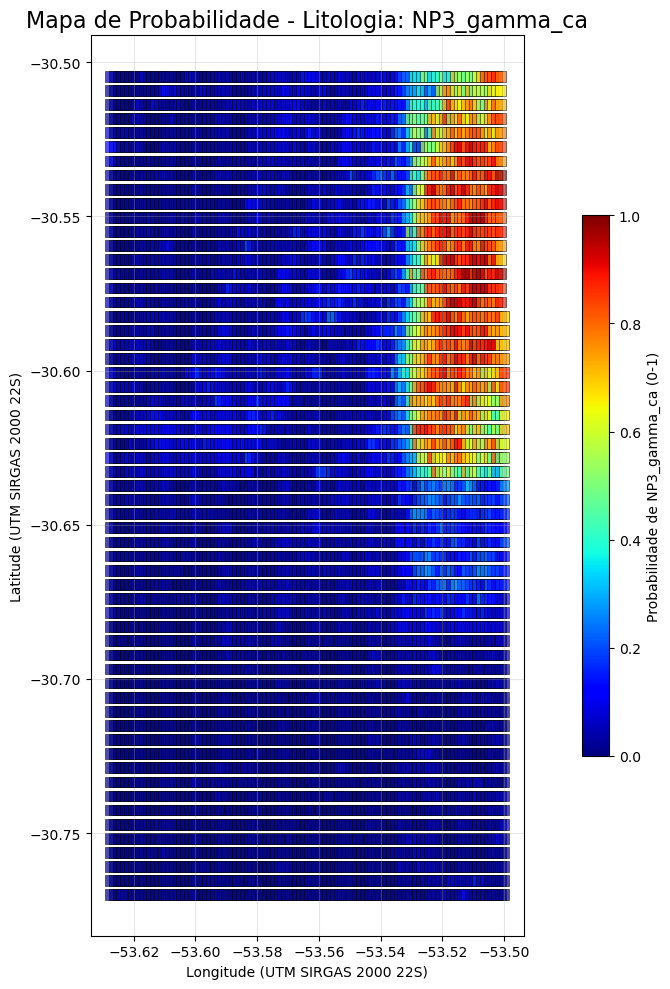

 - Exibindo mapa para: NP3an


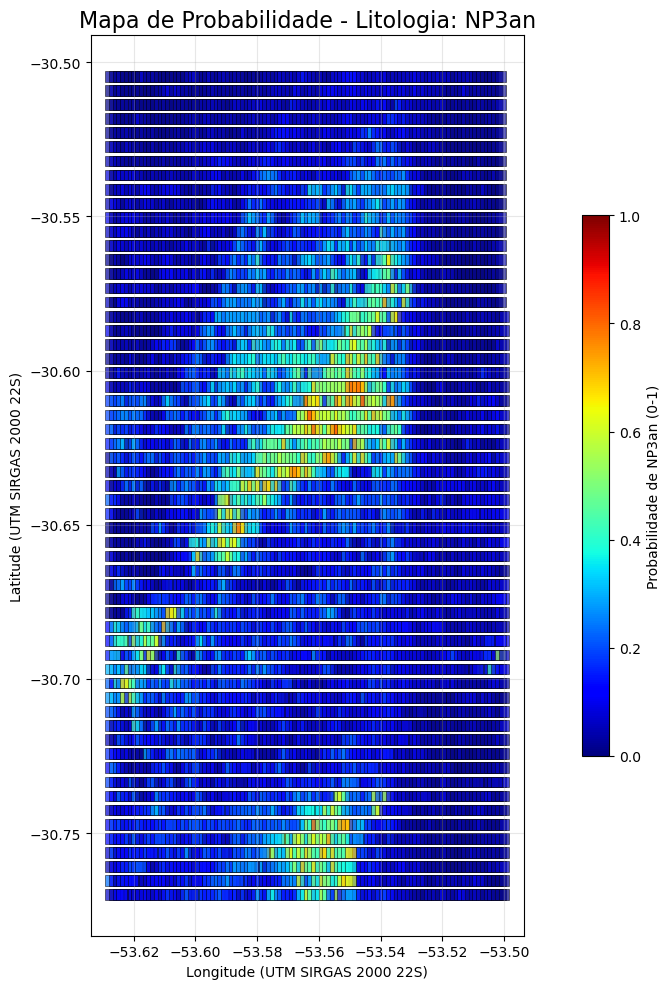

 - Exibindo mapa para: NP3ps


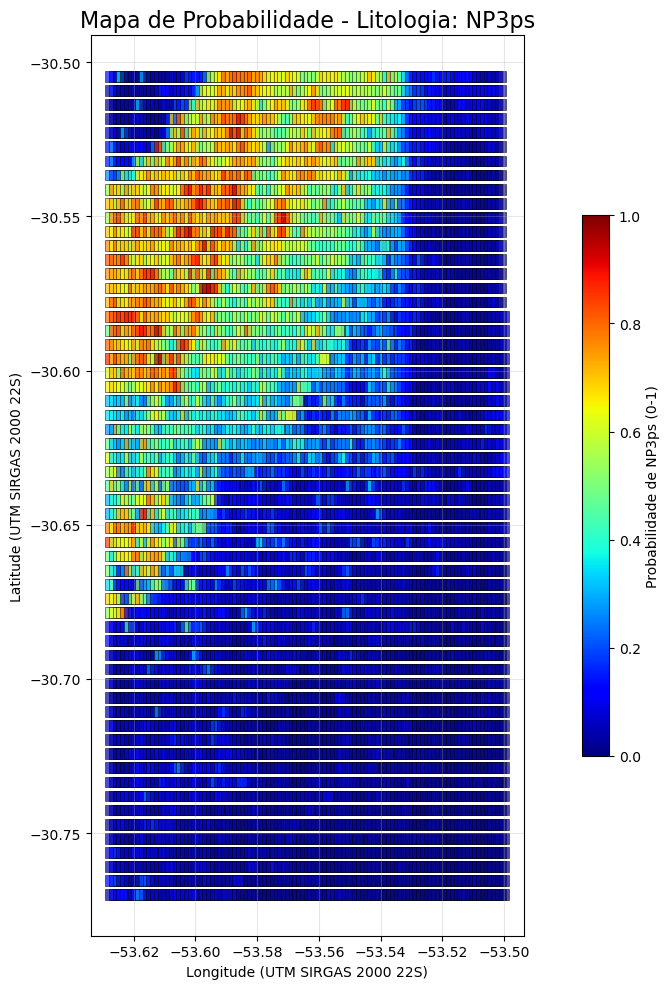


Exibição dos mapas de probabilidade individuais concluída.


In [ ]:
#Criando a variavel de predição
all_probabilities = best_model.predict_proba(X_para_prever)

# 2.2 Obter os nomes das classes (litologias) na ordem correta
lithology_classes = best_model.classes_

# 2.3 Adicionar uma coluna de probabilidade para cada classe ao GeoDataFrame
print("Adicionando colunas de probabilidade ao GeoDataFrame:")
for i, lithology_name in enumerate(lithology_classes):
    prob_col_name = f"Prob_{lithology_name}" # Cria um nome de coluna
    gdf_para_plotar[prob_col_name] = all_probabilities[:, i] # Pega a coluna i de probabilidades
    print(f" - Coluna '{prob_col_name}' adicionada.")

print("\nGeoDataFrame atualizado com probabilidades:")
# Mostra as primeiras linhas das novas colunas e a geometria
cols_to_show = ['geometry'] + [f"Prob_{name}" for name in lithology_classes]
print(gdf_para_plotar[cols_to_show].head())



# Plotar um mapa para cada Litologia 

print("\nGerando e exibindo mapas de probabilidade:")

# 2.1 Loop através de cada litologia (certifique-se que 'lithology_classes' está definido)
for lithology_name in lithology_classes: # Use a variável que contém os nomes das classes
    prob_col_name = f"Prob_{lithology_name}" # Nome da coluna de probabilidade

    # Verifica se a coluna de probabilidade realmente existe no GDF
    if prob_col_name not in gdf_para_plotar.columns:
        print(f"AVISO: Coluna '{prob_col_name}' não encontrada. Pulando mapa para {lithology_name}.")
        continue # Pula para a próxima iteração do loop

    print(f" - Exibindo mapa para: {lithology_name}")

    # 2.2 Configurar a figura para este mapa específico
    # Pode ser útil reduzir um pouco o tamanho se for exibir muitos gráficos
    fig, ax = plt.subplots(figsize=(12, 10)) # Ajustado um pouco o tamanho (opcional)

    # 2.3 Plotar os pontos com cor baseada na probabilidade desta litologia
    gdf_para_plotar.plot(
        ax=ax,
        column=prob_col_name,    # Coluna de probabilidade específica
        cmap='jet',          # Escolha um bom colormap
        marker='s',
        markersize=60,           # Ajustado um pouco o tamanho (opcional)
        alpha=0.7,
        legend=True,
        vmin=0, vmax=1,          # Escala de probabilidade 0 a 1
        edgecolor='k',
        linewidth=0.5,
        legend_kwds={'label': f"Probabilidade de {lithology_name} (0-1)",
                     'orientation': "vertical",
                     'shrink': 0.6}
    )

    # 2.4 Elementos do mapa
    ax.set_title(f'Mapa de Probabilidade - Litologia: {lithology_name}', fontsize=16)
    ax.set_xlabel('Longitude (UTM SIRGAS 2000 22S)')
    ax.set_ylabel('Latitude (UTM SIRGAS 2000 22S)')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # 2.5 Exibir o mapa atual
    plt.show() 

  
print("\nExibição dos mapas de probabilidade individuais concluída.")